Dans ce notebook, vous détaillerez:
- Comment modéliser le problème, en insistant sur les entrées et les sorties attendues par le modèle.
- le prétraitement des données
- l'architecture du modèle retenu
- listez les hyper paramètres qui pourraient faire l'objet d'un tuning
- montrer comment faire ce tuning, (mais vous pouvez ne pas tout tester, ce serait trop long).
- évaluation détaillée
- commentaires et conclusion
- qu'auriez vous aimer ajouter ? qu'est-ce qui a manqué pour cela et comment s'y prendre si on avait plus de temps ?

# 1. Modélisation du problème

Le problème traité est la prédiction de séquences de caractères chinois à partir de séquences numériques issues du clavier T9, représentant la transcription phonétique pinyin. Ce modèle vise à faciliter la saisie rapide en chinois sur des dispositifs numériques à clavier limité.

**Entrée du modèle** : Une séquence de chiffres correspondant à une transcription phonétique pinyin encodée selon le clavier T9.

**Sortie attendue** : Une séquence de caractères chinois correspondant exactement à la transcription phonétique d'entrée.

Exemple concret :

Entrée T9 : 4664 (pinyin : hong) <br>
Sortie attendue : 红

## Importation des bibliothèques

In [1]:
import os
import re
import csv
import gc
import random
import time
import pickle as pk

import pandas as pd
import numpy as np
import jieba

import tensorflow as tf
from keras.models import Model
from keras.layers import (
    LSTM,
    Dense,
    Embedding,
    Input,
    StringLookup,
    TextVectorization,
)
import keras
import keras_hub
import keras_tuner

from datasets import Dataset
from pypinyin import lazy_pinyin
from lxml import etree

from outils import *
from typing import List, Tuple

import kagglehub

print(tf.config.list_physical_devices("GPU"))

os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 2. Prétraitement des données

Le prétraitement réalisé comprend :

- Chargement initial des données depuis des fichiers textes contenant des couples (pinyin, caractère chinois).
- Conversion du pinyin en séquences numériques via le clavier T9 : par exemple, "hong" → 4664.
- Vectorisation numérique : tokenisation par caractère et encodage numérique des caractères chinois et des chiffres T9.
- Padding uniforme des séquences pour obtenir une taille constante adaptée au traitement par batch dans le modèle.

Exemple de transformation :

Original : ("hong", "红") <br>
Prétraité : ([4,6,6,4], [红])

## Corpus Kaggle

In [ ]:
path = kagglehub.dataset_download("noxmoon/chinese-official-daily-news-since-2016")
print("Path to dataset files:", path)
dataset = pd.read_csv(path+"/chinese_news.csv")

# Imprimer des informations sur l'ensemble de données
print("Dataset information:")
print(dataset.info())

# Imprimer la tête de l'ensemble de données
print("Dataset head:")
print(dataset.head())

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20738 entries, 0 to 20737
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      20738 non-null  object
 1   tag       20738 non-null  object
 2   headline  20738 non-null  object
 3   content   20631 non-null  object
dtypes: object(4)
memory usage: 648.2+ KB
None
Dataset head:
         date   tag                                           headline  \
0  2016-01-01  详细全文  陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队...   
1  2016-01-01  详细全文                             中央军委印发《关于深化国防和军队改革的意见》   
2  2016-01-01  详细全文                           《习近平关于严明党的纪律和规矩论述摘编》出版发行   
3  2016-01-01  详细全文                                 以实际行动向党中央看齐 向高标准努力   
4  2016-01-01  详细全文                                 【年终特稿】关键之年 改革挺进深水区   

                                             content  
0  中国人民解放军陆军领导机构、中国人民解放军火箭军、中国人民解放军战略支援部队成立大会2015...  
1  经中央军委主席习近平批准，中央军委近日印发了《关

In [ ]:
# Remplacer les valeurs manquantes par une chaîne vide
dataset["content"] = dataset["content"].fillna("")

# Appliquer le prétraitement à la colonne 'content'
dataset['cleaned_content'] = dataset['content'].apply(clean_content)

# Filtrer les lignes où 'cleaned_content' est vide
dataset = dataset[dataset["cleaned_content"].str.strip() != ""].reset_index(drop=True)

# Afficher les 5 premières lignes du DataFrame après le prétraitement
print("Dataset after preprocessing:")
print(dataset[['content', 'cleaned_content']].head())

dataset["tokens"] = dataset["cleaned_content"].apply(lambda x: list(jieba.cut(x)))

# Aperçu
print(dataset["tokens"].head())

Dataset after preprocessing:
                                             content  \
0  中国人民解放军陆军领导机构、中国人民解放军火箭军、中国人民解放军战略支援部队成立大会2015...   
1  经中央军委主席习近平批准，中央军委近日印发了《关于深化国防和军队改革的意见》。\n《意见》强...   
2  由中共中央纪律检查委员会、中共中央文献研究室编辑的《习近平关于严明党的纪律和规矩论述摘编》一...   
3  广大党员干部正在积极学习习近平总书记在中央政治局专题民主生活会上的重要讲话。大家纷纷表示要把...   
4  刚刚过去的2015年，是全面深化改革的关键之年。改革集中发力在制约经济社会发展的深层次矛盾，...   

                                     cleaned_content  
0  中国人民解放军陆军领导机构、中国人民解放军火箭军、中国人民解放军战略支援部队成立大会年月日在...  
1  经中央军委主席习近平批准，中央军委近日印发了《关于深化国防和军队改革的意见》。《意见》强调，...  
2  由中共中央纪律检查委员会、中共中央文献研究室编辑的《习近平关于严明党的纪律和规矩论述摘编》一...  
3  广大党员干部正在积极学习习近平总书记在中央政治局专题民主生活会上的重要讲话。大家纷纷表示要把...  
4  刚刚过去的年，是全面深化改革的关键之年。改革集中发力在制约经济社会发展的深层次矛盾，集中发力...  
0    [中国, 人民, 解放军, 陆军, 领导, 机构, 、, 中国, 人民, 解放军, 火箭军,...
1    [经, 中央军委, 主席, 习近平, 批准, ，, 中央军委, 近日, 印发, 了, 《, ...
2    [由, 中共中央, 纪律, 检查, 委员会, 、, 中共中央, 文献, 研究室, 编辑, 的...
3    [广大, 党员, 干部, 正在, 积极, 学习, 习近平, 总书记, 在, 中央, 政治局,...
4    [刚刚, 过去, 的, 年, ，, 是, 全面, 深化, 改革, 的, 关键, 之, 年, ...
Name: tokens, dtype: object


In [ ]:
# Convertir le texte en code T9
dataset["char_pinyin_t9_sequence"] = dataset.apply(generer_sequence_contextuelle, axis=1)

# Filtrer les lignes où 'char_pinyin_t9_sequence' est vide
dataset = dataset[dataset["char_pinyin_t9_sequence"].str.strip() != ""].reset_index(drop=True)

# Sauvegarder le fichier
if not tf.io.gfile.exists("corpus"):
    tf.io.gfile.makedirs("corpus")
dataset[["char_pinyin_t9_sequence"]].to_csv("corpus/sequences_char_pinyin_t9.csv", index=False)

# Afficher les 5 premières lignes du DataFrame après le prétraitement
print("Dataset after generating sequences:")
print(dataset[['content', 'char_pinyin_t9_sequence']].head())

Dataset after generating sequences:
                                             content  \
0  中国人民解放军陆军领导机构、中国人民解放军火箭军、中国人民解放军战略支援部队成立大会2015...   
1  经中央军委主席习近平批准，中央军委近日印发了《关于深化国防和军队改革的意见》。\n《意见》强...   
2  由中共中央纪律检查委员会、中共中央文献研究室编辑的《习近平关于严明党的纪律和规矩论述摘编》一...   
3  广大党员干部正在积极学习习近平总书记在中央政治局专题民主生活会上的重要讲话。大家纷纷表示要把...   
4  刚刚过去的2015年，是全面深化改革的关键之年。改革集中发力在制约经济社会发展的深层次矛盾，...   

                             char_pinyin_t9_sequence  
0  中|zhong|94664 国|guo|486 人|ren|736 民|min|646 解|...  
1  经|jing|5464 中|zhong|94664 央|yang|9264 军|jun|58...  
2  由|you|968 中|zhong|94664 共|gong|4664 中|zhong|94...  
3  广|guang|48264 大|da|32 党|dang|3264 员|yuan|9826 ...  
4  刚|gang|4264 刚|gang|4264 过|guo|486 去|qu|78 的|de...  


## Corpus XML

In [42]:
chinese_directory = "LCMC/2474/Lcmc/data/character/"
pinyin_directory = "LCMC/2474/Lcmc/data/pinyin/"
xml_corpus_to_csv = "corpus/pinyin_char.csv"

def get_text_from_xml(xml_file):
    """
    Extract text from XML file, handling different tags and ensuring correct punctuation.
    Args:
        xml_file (str): Path to the XML file.

    Returns:
        sentences (list): List of extracted sentences with correct punctuation.
    """
    sentences = []
    try:
        tree = etree.parse(xml_file)
        root = tree.getroot()

        for text_elem in root.iter("text"):
            for paragraph in text_elem.iter("p"):
                for sentence_elem in paragraph.iter("s"):
                    sentence_text = ""
                    for child in sentence_elem.iter("w", "c"):
                        if child.text:
                            sentence_text += child.text.strip()
                    if sentence_text:
                        # Remove unnecessary spaces
                        sentence_text = ''.join(sentence_text.split())
                        sentences.append(sentence_text)
    except etree.XMLSyntaxError as e:
        print(f"Error parsing XML {xml_file}: {e}")
        return []
    return sentences

def process_xml_directories(pinyin_directory, chinese_directory):
    """
    Process XML files in pinyin and Chinese directories, extracting and concatenating text.
    Args:
        pinyin_directory (str): Path to directory containing pinyin XML files.
        chinese_directory (str): Path to directory containing Chinese character XML files.

    Returns:
        filename_pinyin (dict): Dictionary mapping pinyin XML filenames to concatenated text.
        filename_char (dict): Dictionary mapping Chinese XML filenames to concatenated text.
    """
    filename_pinyin = {}
    filename_char = {}

    # Process pinyin XML files
    for filename in os.listdir(pinyin_directory):
        if filename.lower().endswith(".xml"):
            file_path = os.path.join(pinyin_directory, filename)
            sentences = get_text_from_xml(file_path)
            if sentences:
                # Concatenate sentences with spaces (or no spaces, depending on preference)
                concatenated_text = ''.join(sentences)  # No spaces for pinyin
                filename_pinyin[filename.lower()] = concatenated_text
            else:
                print(f"No text extracted from {filename}")

    # Process Chinese character XML files
    for filename in os.listdir(chinese_directory):
        if filename.lower().endswith(".xml"):
            file_path = os.path.join(chinese_directory, filename)
            sentences = get_text_from_xml(file_path)
            if sentences:
                # Concatenate sentences with spaces (or no spaces, depending on preference)
                concatenated_text = ''.join(sentences)  # No spaces for Chinese
                filename_char[filename.lower()] = concatenated_text
            else:
                print(f"No text extracted from {filename}")

    return filename_pinyin, filename_char

filename_pinyin, filename_char = process_xml_directories(pinyin_directory, chinese_directory)

# # Print results
# print("Pinyin files:")
# for filename, text in filename_pinyin.items():
#     print(f"{filename}: {text}")

# print("\nChinese character files:")
# for filename, text in filename_char.items():
#     print(f"{filename}: {text}")


In [43]:
def create_csv(filename_char, filename_pinyin, output_file=xml_corpus_to_csv):
    """
    Create a CSV file from Chinese character and pinyin XML files.
    The CSV contains columns for Content (Chinese text) and Pinyin (pinyin text).
    Args:
        filename_char (dict): Dictionary mapping filenames to concatenated Chinese text.
        filename_pinyin (dict): Dictionary mapping filenames to concatenated pinyin text.
        output_file (str): Path to the output CSV file (default: 'pinyin_char.csv').

    Returns:
        None
    """
    with open(output_file, "w", encoding="utf-8", newline='') as f:
        # Initialiser l'écrivain CSV
        writer = csv.writer(f, lineterminator='\n')
        # Écrire l'en-tête
        writer.writerow(["content", "pinyin"])
        
        # Itérer sur les fichiers dans filename_char
        for key in filename_char.keys():
            if key not in filename_pinyin:
                print(f"Warning: {key} not found in filename_pinyin")
                continue
            
            # Obtenir les textes chinois et pinyin
            char_text = filename_char[key]
            pinyin_text = filename_pinyin[key]
            
            # Diviser les textes en phrases
            char_sentences = [s.strip() for s in re.split(r'[。；]', char_text) if s.strip()]
            pinyin_sentences = [s.strip() for s in re.split(r'[。；]', pinyin_text) if s.strip()]
            
            # Vérifier la correspondance du nombre de phrases
            if len(char_sentences) != len(pinyin_sentences):
                print(f"Warning: Mismatch in sentence count for {key}: "
                      f"{len(char_sentences)} Chinese vs {len(pinyin_sentences)} pinyin")
                min_sentences = min(len(char_sentences), len(pinyin_sentences))
                char_sentences = char_sentences[:min_sentences]
                pinyin_sentences = pinyin_sentences[:min_sentences]
            
            # Écrire chaque paire de phrases dans le CSV
            for char_sent, pinyin_sent in zip(char_sentences, pinyin_sentences):
                # Nettoyer le texte pour éviter les problèmes de format CSV
                char_sent = char_sent.replace("\n", " ").replace("\r", " ")
                pinyin_sent = pinyin_sent.replace("\n", " ").replace("\r", " ")
                writer.writerow([char_sent, pinyin_sent])

# Appeler la fonction pour créer le fichier CSV
create_csv(filename_char, filename_pinyin)

In [44]:
new_dataset = pd.read_csv(xml_corpus_to_csv)

# Inspectez le dataframe pour les valeurs NAN
print("Inspecting DataFrame for NaN values:")
print(new_dataset.isna().sum())
print("\nSample rows:")
print(new_dataset.head())


# Remplacez NaN par des chaînes vides pour éviter TypeError
new_dataset["content"] = new_dataset["content"].fillna("")
new_dataset["pinyin"] = new_dataset["pinyin"].fillna("")

# Ajouter la colonne 'char_pinyin_t9_sequence' à dataframe
new_dataset["char_pinyin_t9_sequence"] = new_dataset.apply(
    lambda x: generer_sequence_contextuelle_new(x["content"], x["pinyin"]), axis=1
).fillna("")

print("\nT9 Rows:")
print(new_dataset["char_pinyin_t9_sequence"].head())

print("Inspecting DataFrame for NaN values:")
print(new_dataset.isna().sum())

new_dataset.to_csv(xml_corpus_to_csv, index=False)
print("CSV file updated successfully")

Inspecting DataFrame for NaN values:
content    0
pinyin     0
dtype: int64

Sample rows:
                                       content  \
0                          云在天空游荡，它从远方飘来，又飘向远方   
1           从来没有人知道云的故乡在哪里？云的归处是何方？这就是藏花喜欢云的原因   
2                           她现在就躺在绿草上，凝视着天空的云彩   
3  今天是正月十五，是元宵节，是她这种年纪欢愉的节日可是她却宁愿独自躺在这一片寂寞的草原上   
4        每逢过年佳节，她总是一个人躲得远远的，躲入一片空寂中，躲入自己内心的天空里   

                                              pinyin  
0  yun2zai4tian1kong1you2dang4，ta1cong2yuan3fang1...  
1  cong2lai2mei2you3ren2zhi1dao4yun2de5gu4xiang1z...  
2  ta1xian4zai4jiu4tang3zai4luu4cao3shang4，ning2s...  
3  jin1tian1shi4zheng4yue4shi2wu3，shi4yuan2xiao1j...  
4  mei3feng2guo4nian2jia1jie2，ta1zong3shi4yi1ge4r...  

T9 Rows:
0    云|yun|986 在|zai|924 天|tian|8426 空|kong|5664 游|...
1    从|cong|2664 来|lai|524 没|mei|634 有|you|968 人|re...
2    她|ta|82 现|xian|9426 在|zai|924 就|jiu|548 躺|tang...
3    今|jin|546 天|tian|8426 是|shi|744 正|zheng|94364 ...
4    每|mei|634 逢|feng|3364 过|guo|486 年|nian|6426 

## Création du dataset pour le modèle

In [8]:
# csv_file_path = "corpus/sequences_char_pinyin_t9.csv"
csv_file_path = "corpus/pinyin_char.csv"

dataset = pd.read_csv(csv_file_path)

In [9]:
# Transformer en séquences complètes
input_t9_sequences = []
target_char_sequences = []
MAX_SEQUENCE_LENGTH = 20

for seq in dataset["char_pinyin_t9_sequence"]:
    if pd.isna(seq):
        continue  # Ignore les valeurs NaN
    triplets = seq.strip().split(" ")
    t9_seq = []
    char_seq = []
    
    # Extraire les paires char|T9 pour chaque phrase
    for triplet in triplets[:MAX_SEQUENCE_LENGTH]:  # Tronquer à MAX_SEQUENCE_LENGTH
        parts = triplet.split("|")
        if len(parts) == 3:
            char, _, t9 = parts
            if validate_t9(t9):  # Vérifier que le T9 est valide
                char_seq.append(char)
                t9_seq.append(t9)
    
    # Ajouter les séquences T9 et caractères si non vides
    if t9_seq and char_seq:
        input_t9_sequences.append(" ".join(t9_seq))
        target_char_sequences.append("".join(char_seq)) # A voir si on garde les espaces ou pas

# Créer un DataFrame
df_sequences = pd.DataFrame({
    "input_t9_sequence": input_t9_sequences,
    "target_char_sequence": target_char_sequences
})

# Filtrer les séquences vides (par précaution)
df_sequences = df_sequences[df_sequences["input_t9_sequence"].str.strip() != ""]
df_sequences = df_sequences[df_sequences["target_char_sequence"].str.strip() != ""]

In [10]:
print("DataFrame sequences:")
print(df_sequences.head())

DataFrame sequences:
                                   input_t9_sequence  target_char_sequence
0  986 924 8426 5664 968 3264 82 2664 9826 3264 7...     云在天空游荡它从远方飘来又飘向远方
1  2664 524 634 968 736 944 326 986 33 48 94264 9...  从来没有人知道云的故乡在哪里云的归处是何
2  82 9426 924 548 8264 924 588 226 74264 6464 74...     她现在就躺在绿草上凝视着天空的云彩
3  546 8426 744 94364 983 744 98 744 9826 9426 54...  今天是正月十五是元宵节是她这种年纪欢愉的
4  634 3364 486 6426 542 543 82 9664 744 94 43 73...  每逢过年佳节她总是一个人躲得远远的躲入一


In [11]:
# Utiliser tf.data.Dataset
tf_dataset = tf.data.Dataset.from_tensor_slices((df_sequences['input_t9_sequence'], df_sequences['target_char_sequence'])).prefetch(tf.data.AUTOTUNE)
tf_dataset.take(1).get_single_element()

(<tf.Tensor: shape=(), dtype=string, numpy=b'986 924 8426 5664 968 3264 82 2664 9826 3264 7426 524 968 7426 94264 9826 3264'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'\xe4\xba\x91\xe5\x9c\xa8\xe5\xa4\xa9\xe7\xa9\xba\xe6\xb8\xb8\xe8\x8d\xa1\xe5\xae\x83\xe4\xbb\x8e\xe8\xbf\x9c\xe6\x96\xb9\xe9\xa3\x98\xe6\x9d\xa5\xe5\x8f\x88\xe9\xa3\x98\xe5\x90\x91\xe8\xbf\x9c\xe6\x96\xb9'>)

### Encoder les données pour Keras

In [12]:
# TextVectorization
input_tv = keras.layers.TextVectorization(output_mode='int',
                                          split='character',
                                          standardize=None,
                                          ragged=True,)

target_tv = keras.layers.TextVectorization(output_mode='int',
                                           split='character',
                                           standardize=None,
                                           ragged=True,)

tmp_t9_ds = tf_dataset.map(lambda t9, target: tf.strings.reduce_join(tf.strings.split(t9, " "), separator=""))
t9_ds = tf_dataset.map(lambda t9, target: t9)
target_ds = tf_dataset.map(lambda t9, target: target)
input_tv.adapt(tmp_t9_ds)
target_tv.adapt(target_ds)

In [13]:
# Le vocabulaire pour t9 input
print(input_tv.get_vocabulary())
print(target_tv.get_vocabulary())

# Sauvegarder les vectorisateurs
with open("data/input_vectorizer.pkl", "wb") as f:
    pk.dump(input_tv, f)
    print("Input vectorizer saved successfully.")

with open("data/target_vectorizer.pkl", "wb") as f:
    pk.dump(target_tv, f)
    print("Target vectorizer saved successfully.")


['', '[UNK]', np.str_('4'), np.str_('6'), np.str_('2'), np.str_('3'), np.str_('9'), np.str_('8'), np.str_('7'), np.str_('5')]
['', '[UNK]', np.str_('的'), np.str_('一'), np.str_('是'), np.str_('在'), np.str_('不'), np.str_('了'), np.str_('人'), np.str_('有'), np.str_('这'), np.str_('我'), np.str_('他'), np.str_('个'), np.str_('中'), np.str_('上'), np.str_('大'), np.str_('国'), np.str_('为'), np.str_('来'), np.str_('年'), np.str_('要'), np.str_('和'), np.str_('时'), np.str_('说'), np.str_('到'), np.str_('地'), np.str_('们'), np.str_('对'), np.str_('生'), np.str_('学'), np.str_('就'), np.str_('以'), np.str_('子'), np.str_('家'), np.str_('会'), np.str_('出'), np.str_('着'), np.str_('于'), np.str_('后'), np.str_('过'), np.str_('也'), np.str_('下'), np.str_('用'), np.str_('经'), np.str_('自'), np.str_('发'), np.str_('可'), np.str_('多'), np.str_('她'), np.str_('你'), np.str_('成'), np.str_('能'), np.str_('工'), np.str_('作'), np.str_('小'), np.str_('同'), np.str_('得'), np.str_('天'), np.str_('里'), np.str_('那'), np.str_('如'), np.str_('然'), np.str

In [14]:
@tf.function
def split_and_vectorize(t9_seq, char_seq, context_size=5):
    
    # Split chaque séquence T9 (par espace)
    t9_parts = tf.strings.split(t9_seq, " ")  # tf.TensorShape([None])

    # Split la séquence de caractères (par caractère UTF-8)
    char_parts = tf.strings.unicode_split(char_seq, "UTF-8")

    # Padder la séquence de caractères pour avoir le contexte pour tous les caractères
    char_seq_padded = tf.strings.join([tf.constant("     "), char_seq])
    char_parts_padded = tf.strings.unicode_split(char_seq_padded, "UTF-8")

    # Vérification de la même longueur entre la séquence de t9 et celle de caractères
    assert_op = tf.debugging.assert_equal(tf.shape(t9_parts)[0], tf.shape(char_parts)[0])

    with tf.control_dependencies([assert_op]):
        
        # Vectorisation : chaque chiffre dans chaque t9_part est un caractère
        vectorized_t9 = input_tv(t9_parts)       # RaggedTensor: [nb_sous_seq, longueur_t9]
        vectorized_target = target_tv(char_parts)  # RaggedTensor: [nb_sous_seq, 1]

        # Convertit RaggedTensor en Tensor avec padding (0 par défaut, qui sera ignoré lors du Embedding Layer, mask_zero=True)
        t9_tensor = vectorized_t9.to_tensor(default_value=0)
        target_tensor = vectorized_target.to_tensor(default_value=0)
        target_tensor = tf.squeeze(target_tensor, axis=-1)
        
        # Contexte
        # Vectorisation du target padded
        vectorized_target_padded = target_tv(char_parts_padded).to_tensor(default_value=0)
        # Avoir la longueur de caractères après le padding
        padded_seq_len = tf.shape(vectorized_target_padded)[0]
        # Initialiser un tenseur pour le contexte
        contexts = tf.TensorArray(dtype=tf.int64, size=padded_seq_len - context_size)
        # Parcourir chaque caractère sauf le dernier
        for i in tf.range(padded_seq_len - context_size):
            # Récupérer dynamiquement un contexte de taille fixe
            context = vectorized_target_padded[i:i+context_size]
            # Écrire dans la position correspondante du tenseur array
            contexts = contexts.write(i, context)
        # Piler le tenseur
        contexts_tensor = contexts.stack()
        contexts_tensor = tf.squeeze(contexts_tensor, axis=-1)

        return {"t9_input": t9_tensor, "context_input": contexts_tensor}, target_tensor

transformed_dataset = tf_dataset.map(
    lambda t9, target: split_and_vectorize(t9, target),
    num_parallel_calls=20
)

In [15]:
transformed_dataset.padded_batch(256).take(1).get_single_element()

({'t9_input': <tf.Tensor: shape=(256, 20, 6), dtype=int64, numpy=
  array([[[6, 7, 3, 0, 0, 0],
          [6, 4, 2, 0, 0, 0],
          [7, 2, 4, 3, 0, 0],
          ...,
          [0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0]],
  
         [[4, 3, 3, 2, 0, 0],
          [9, 4, 2, 0, 0, 0],
          [3, 5, 2, 0, 0, 0],
          ...,
          [4, 2, 7, 0, 0, 0],
          [8, 2, 2, 0, 0, 0],
          [2, 5, 0, 0, 0, 0]],
  
         [[7, 4, 0, 0, 0, 0],
          [6, 2, 4, 3, 0, 0],
          [6, 4, 2, 0, 0, 0],
          ...,
          [0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0]],
  
         ...,
  
         [[9, 3, 3, 2, 0, 0],
          [5, 5, 2, 0, 0, 0],
          [8, 4, 3, 0, 0, 0],
          ...,
          [9, 4, 2, 0, 0, 0],
          [0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0]],
  
         [[6, 4, 3, 0, 0, 0],
          [7, 7, 0, 0, 0, 0],
          [6, 2, 2, 0, 0, 0],
          ...,
          [5, 8,

## Split train-valid-test

In [16]:
c = transformed_dataset.reduce(0, lambda x,_:x+1).numpy()

shuffled_ds = transformed_dataset.shuffle(buffer_size=c, seed=42)

train_size = c * 80 // 100
test_size = c * 10 // 100
val_size = c - train_size - test_size

ds_train = shuffled_ds.take(train_size).prefetch(tf.data.AUTOTUNE)
ds_val = shuffled_ds.skip(train_size).take(val_size).prefetch(tf.data.AUTOTUNE)
ds_test = shuffled_ds.skip(train_size+val_size).take(test_size).prefetch(tf.data.AUTOTUNE)

print("Taille du train :", ds_train.cardinality().numpy())
print("Taille du validation :", ds_val.cardinality().numpy())
print("Taille du test :", ds_test.cardinality().numpy())

Taille du train : 29874
Taille du validation : 3735
Taille du test : 3734


In [37]:
context_size = 5

def pad_t9_input(inputs, labels, t9_dim=6):
    """
    Pad the T9 input to a fixed size. If the input is shorter, it will be padded with zeros.
    If the input is longer, it will be truncated.

    Args:
        inputs (dict): Dictionary containing the input tensors.
        labels (tf.Tensor): Tensor containing the labels.
        t9_dim (int): Fixed size for T9 input.
    Returns:
        tuple: Tuple containing the padded inputs and labels.
    """
    t9_input = inputs["t9_input"]
    t9_input = t9_input[:, :t9_dim]  # Truncate second dimension
    seq_len = tf.shape(t9_input)[0]
    current_dim = tf.shape(t9_input)[1]
    paddings = [[0, 0], [0, tf.maximum(0, t9_dim - current_dim)]]
    t9_input_padded = tf.pad(t9_input, paddings, constant_values=0)
    return {
        "t9_input": t9_input_padded,
        "context_input": inputs["context_input"]
    }, labels

# Truncate sequence length
def truncate_sequence(inputs, labels, max_length=MAX_SEQUENCE_LENGTH):
    """
    Truncate the sequence to a maximum length. If the sequence is shorter, it will be padded.
    Args:
        inputs (dict): Dictionary containing the input tensors.
        labels (tf.Tensor): Tensor containing the labels.
        max_length (int): Maximum length for the sequence.
    Returns:
        tuple: Tuple containing the truncated inputs and labels.
    """
    return {
        "t9_input": inputs["t9_input"][:max_length],
        "context_input": inputs["context_input"][:max_length]
    }, labels[:max_length]


# Apply to datasets
ds_train = ds_train.map(pad_t9_input).map(truncate_sequence)
ds_val = ds_val.map(pad_t9_input).map(truncate_sequence)
ds_test = ds_test.map(pad_t9_input).map(truncate_sequence)


ds_train_padded = ds_train.padded_batch(
    128,
    padded_shapes=(
        {
            "t9_input": [MAX_SEQUENCE_LENGTH, 6],
            "context_input": [MAX_SEQUENCE_LENGTH, context_size]
        },
        [MAX_SEQUENCE_LENGTH]  # Pour les étiquettes
    ),
    padding_values=(
        {
            "t9_input": tf.constant(0, dtype=tf.int64),
            "context_input": tf.constant(0, dtype=tf.int64)
        },
        tf.constant(0, dtype=tf.int64)  # Pour les étiquettes
    ),
    drop_remainder=True,
).map(lambda x, y: (x, y, y>0)).prefetch(tf.data.AUTOTUNE)

ds_val_padded = ds_val.padded_batch(
    128,
    padded_shapes=(
        {
            "t9_input": [MAX_SEQUENCE_LENGTH, 6],
            "context_input": [MAX_SEQUENCE_LENGTH, context_size]
        },
        [MAX_SEQUENCE_LENGTH]  # Pour les étiquettes
    ),
    padding_values=(
        {
            "t9_input": tf.constant(0, dtype=tf.int64),
            "context_input": tf.constant(0, dtype=tf.int64)
        },
        tf.constant(0, dtype=tf.int64)  # Pour les étiquettes
    ),
    drop_remainder=True,
).map(lambda x, y: (x, y, y>0)).prefetch(tf.data.AUTOTUNE)

ds_test_padded = ds_test.padded_batch(
    128,
    padded_shapes=(
        {
            "t9_input": [MAX_SEQUENCE_LENGTH, 6],
            "context_input": [MAX_SEQUENCE_LENGTH, context_size]
        },
        [MAX_SEQUENCE_LENGTH]  # Pour les étiquettes
    ),
    padding_values=(
        {
            "t9_input": tf.constant(0, dtype=tf.int64),
            "context_input": tf.constant(0, dtype=tf.int64)
        },
        tf.constant(0, dtype=tf.int64)  # Pour les étiquettes
    ),
    drop_remainder=True,
).map(lambda x, y: (x, y, y>0)).prefetch(tf.data.AUTOTUNE)

def test_dataset(dataset, name, max_batches=5):
    print(f"Testing {name}...")
    try:
        for i, (inputs, labels, mask) in enumerate(dataset.take(max_batches)):
            print(f"Batch {i}:")
            print(f"  t9_input shape: {inputs['t9_input'].shape}")
            print(f"  context_input shape: {inputs['context_input'].shape}")
            print(f"  labels shape: {labels.shape}")
        print(f"{name} is valid.")
    except Exception as e:
        print(f"Error in {name}: {e}")

test_dataset(ds_train_padded, "train")
test_dataset(ds_val_padded, "validation")
test_dataset(ds_test_padded, "test")

Testing train...
Batch 0:
  t9_input shape: (128, 20, 6)
  context_input shape: (128, 20, 5)
  labels shape: (128, 20)
Batch 1:
  t9_input shape: (128, 20, 6)
  context_input shape: (128, 20, 5)
  labels shape: (128, 20)
Batch 2:
  t9_input shape: (128, 20, 6)
  context_input shape: (128, 20, 5)
  labels shape: (128, 20)
Batch 3:
  t9_input shape: (128, 20, 6)
  context_input shape: (128, 20, 5)
  labels shape: (128, 20)
Batch 4:
  t9_input shape: (128, 20, 6)
  context_input shape: (128, 20, 5)
  labels shape: (128, 20)
train is valid.
Testing validation...
Batch 0:
  t9_input shape: (128, 20, 6)
  context_input shape: (128, 20, 5)
  labels shape: (128, 20)
Batch 1:
  t9_input shape: (128, 20, 6)
  context_input shape: (128, 20, 5)
  labels shape: (128, 20)
Batch 2:
  t9_input shape: (128, 20, 6)
  context_input shape: (128, 20, 5)
  labels shape: (128, 20)
Batch 3:
  t9_input shape: (128, 20, 6)
  context_input shape: (128, 20, 5)
  labels shape: (128, 20)
Batch 4:
  t9_input shape: 

In [38]:
# Tailles
print("Taille du train :", ds_train_padded.cardinality().numpy())
print("Taille du validation :", ds_val_padded.cardinality().numpy())
print("Taille du test :", ds_test_padded.cardinality().numpy())

Taille du train : 233
Taille du validation : 29
Taille du test : 29


In [39]:
ds_train_padded.take(1).get_single_element()

({'t9_input': <tf.Tensor: shape=(128, 20, 6), dtype=int64, numpy=
  array([[[6, 2, 3, 3, 2, 0],
          [2, 3, 3, 2, 0, 0],
          [6, 2, 3, 3, 2, 0],
          ...,
          [5, 4, 3, 0, 0, 0],
          [5, 5, 0, 0, 0, 0],
          [5, 7, 3, 0, 0, 0]],
  
         [[2, 5, 0, 0, 0, 0],
          [9, 2, 0, 0, 0, 0],
          [5, 7, 0, 0, 0, 0],
          ...,
          [8, 2, 2, 0, 0, 0],
          [5, 5, 0, 0, 0, 0],
          [9, 2, 3, 0, 0, 0]],
  
         [[7, 5, 0, 0, 0, 0],
          [4, 2, 5, 0, 0, 0],
          [8, 2, 2, 0, 0, 0],
          ...,
          [4, 7, 0, 0, 0, 0],
          [9, 2, 7, 0, 0, 0],
          [6, 2, 4, 3, 0, 0]],
  
         ...,
  
         [[6, 5, 2, 0, 0, 0],
          [9, 5, 0, 0, 0, 0],
          [8, 2, 2, 0, 0, 0],
          ...,
          [6, 5, 3, 2, 0, 0],
          [8, 2, 4, 3, 2, 0],
          [6, 2, 2, 0, 0, 0]],
  
         [[6, 4, 3, 0, 0, 0],
          [8, 7, 4, 3, 0, 0],
          [8, 5, 3, 0, 0, 0],
          ...,
          [6, 2,

In [40]:
if not tf.io.gfile.exists("data"):
    tf.io.gfile.makedirs("data")

# Sauvegarder les paramètres
params = {
    "MAX_SEQUENCE_LENGTH": MAX_SEQUENCE_LENGTH,
    "context_size": context_size,
    "input_vocab_size": len(input_tv.get_vocabulary()),
    "target_vocab_size": len(target_tv.get_vocabulary()),
}

with open("data/params.pkl", "wb") as f:
    pk.dump(params, f)
    print("Parameters saved successfully.")


Parameters saved successfully.


In [41]:
# Sauvegarder les jeux de données
tf.data.Dataset.save(ds_val_padded, "data/val_dataset")
print("Validation dataset saved successfully.")
tf.data.Dataset.save(ds_test_padded, "data/test_dataset")
print("Test dataset saved successfully.")
tf.data.Dataset.save(ds_train_padded, "data/train_dataset")
print("Train dataset saved successfully.")

Validation dataset saved successfully.
Test dataset saved successfully.
Train dataset saved successfully.


In [42]:
ds_train_padded.take(1).get_single_element()

({'t9_input': <tf.Tensor: shape=(128, 20, 6), dtype=int64, numpy=
  array([[[3, 4, 0, 0, 0, 0],
          [2, 7, 3, 0, 0, 0],
          [6, 2, 3, 0, 0, 0],
          ...,
          [5, 8, 0, 0, 0, 0],
          [6, 7, 0, 0, 0, 0],
          [3, 7, 7, 0, 0, 0]],
  
         [[7, 4, 0, 0, 0, 0],
          [5, 7, 2, 0, 0, 0],
          [6, 3, 0, 0, 0, 0],
          ...,
          [2, 5, 3, 0, 0, 0],
          [7, 5, 0, 0, 0, 0],
          [8, 2, 7, 0, 0, 0]],
  
         [[9, 7, 0, 0, 0, 0],
          [5, 5, 3, 0, 0, 0],
          [6, 2, 0, 0, 0, 0],
          ...,
          [8, 2, 3, 2, 0, 0],
          [7, 2, 0, 0, 0, 0],
          [2, 4, 3, 0, 0, 0]],
  
         ...,
  
         [[6, 2, 4, 3, 0, 0],
          [6, 2, 0, 0, 0, 0],
          [9, 4, 2, 0, 0, 0],
          ...,
          [4, 2, 7, 0, 0, 0],
          [0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0]],
  
         [[7, 4, 0, 0, 0, 0],
          [3, 4, 0, 0, 0, 0],
          [6, 5, 2, 0, 0, 0],
          ...,
          [2, 5,

# 3. Modèles

Modèle pris comme exemple : Sogou T9 est une méthode d’entrée intelligente qui :

- Prend des séquences numériques (ex. : "94664 486" pour "zhong guo").
- Génère des séquences de caractères chinois (ex. : "中国").
- Utilise le contexte (mots précédents) pour désambiguïser les prédictions.
- Est optimisé pour la vitesse et la précision, souvent avec des modèles entraînés sur de vastes corpus.

Pour reproduire cela, il faut utiliser un modèle seq2seq avec un encodeur-décodeur (2 entrées) :

- Encodeur : Lit la séquence T9 et la compresse en une représentation contextuelle.
- Décodeur : Génère la séquence de caractères chinois à partir de cette représentation.

[Functional API](https://keras.io/guides/functional_api/)
[Introduction Seq2Seq](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)

**Deux architectures distinctes ont été implémentées et évaluées :**

1. Modèle GRU simple / Modèle GRU avec masquage des id 1

- Embedding pour les entrées T9 et les contextes.
- Masquage des tokens spéciaux avec une couche personnalisée (MaskToken1Layer).
- Couches GRU séparées pour encoder les séquences T9 et contextuelles. 
- Concaténation des représentations encodées par GRU.
- Couche Dense finale avec activation softmax pour prédire les caractères chinois.

    Cette architecture exploite efficacement la capacité des couches GRU à gérer les dépendances temporelles dans les séquences.

2. Modèle GRU avec Transformer

    Reprends le modèle précédent mais ajout d'un bloc transformer.

- Embedding et masquage initial identiques au modèle GRU simple.
- Encodage GRU suivi d'un embedding positionnel pour intégrer la notion d'ordre des tokens.
- Blocs Transformer (attention multi-têtes) appliqués séparément sur les représentations issues des GRU pour les séquences T9 et contextuelles.
- Concaténation des deux représentations transformées.
- Couche Dense finale avec activation softmax pour prédire les caractères chinois.

    Cette architecture ajoute une capacité accrue à capturer des relations complexes grâce aux mécanismes d’attention multi-têtes du Transformer.

## Hyperparamètres à tuner

Les hyperparamètres retenus pour le tuning sont :

- Dimension des embeddings des chiffres et des caractères.
- Nombre d'unités des couches GRU.
- Nombre de têtes d’attention dans les Transformers (pour le deuxième modèle).
- Taux d'apprentissage (learning_rate).
- Taille des batches utilisés pendant l’entraînement.
- Nombre de couches Transformer.

## Méthode de tuning des hyperparamètres

Le tuning a été effectué en utilisant une approche simplifiée de recherche par grille (Grid Search) avec KerasTuner, en testant des combinaisons limitées en fonction du modèle utilisé.

In [2]:
# Chargement des jeux de données
ds_train_padded = load_dataset("data/train_dataset")
ds_val_padded = load_dataset("data/val_dataset")
ds_test_padded = load_dataset("data/test_dataset")

# Chargement des vectorisateurs
input_tv = load_vectorizer("data/input_vectorizer.pkl")
target_tv = load_vectorizer("data/target_vectorizer.pkl")

# Chargement des paramètres
params = load_params("data/params.pkl")
context_size = params["context_size"]
MAX_SEQUENCE_LENGTH = params["MAX_SEQUENCE_LENGTH"]
input_vocab_size = params["input_vocab_size"]
target_vocab_size = params["target_vocab_size"]


I0000 00:00:1747462446.958781 2485580 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1747462446.958828 2485580 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
ds_train_padded.take(1).get_single_element()

({'t9_input': <tf.Tensor: shape=(128, 20, 6), dtype=int64, numpy=
  array([[[7, 4, 0, 0, 0, 0],
          [2, 7, 4, 3, 0, 0],
          [9, 2, 4, 3, 0, 0],
          ...,
          [5, 5, 3, 0, 0, 0],
          [8, 7, 0, 0, 0, 0],
          [6, 7, 0, 0, 0, 0]],
  
         [[9, 5, 0, 0, 0, 0],
          [8, 2, 2, 0, 0, 0],
          [8, 2, 2, 0, 0, 0],
          ...,
          [6, 4, 3, 0, 0, 0],
          [8, 2, 5, 0, 0, 0],
          [5, 4, 3, 2, 0, 0]],
  
         [[9, 7, 4, 2, 0, 0],
          [9, 2, 0, 0, 0, 0],
          [9, 2, 7, 0, 0, 0],
          ...,
          [6, 2, 0, 0, 0, 0],
          [7, 3, 3, 2, 0, 0],
          [5, 2, 0, 0, 0, 0]],
  
         ...,
  
         [[6, 2, 0, 0, 0, 0],
          [6, 2, 5, 0, 0, 0],
          [4, 2, 0, 0, 0, 0],
          ...,
          [6, 5, 0, 0, 0, 0],
          [6, 4, 3, 0, 0, 0],
          [6, 2, 7, 0, 0, 0]],
  
         [[6, 7, 0, 0, 0, 0],
          [8, 2, 2, 0, 0, 0],
          [6, 2, 2, 0, 0, 0],
          ...,
          [0, 0,

In [4]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Réduit le taux d'apprentissage par 2
    patience=3,  # Après 3 époques sans amélioration
    min_lr=1e-6
)

In [5]:
def build_model(input_tv, output_tv, emb_size, gru_size, dropout=0.3, context_size=5):
    # Inputs
    t9_input = keras.layers.Input(shape=(None, 6), name="t9_input")  # (batch, seq_len, t9_len)
    context_input = keras.layers.Input(shape=(None, context_size), name="context_input")  # (batch, seq_len, context_len)

    # ===== T9 processing =====
    t9_emb = keras.layers.TimeDistributed(
        keras.layers.Embedding(input_dim=input_tv.vocabulary_size(),
                         output_dim=emb_size,
                         mask_zero=True),
        name="t9_embedding")(t9_input)
    
    t9_emb = keras.layers.Dropout(dropout, name="t9_embedding_dropout")(t9_emb)

    t9_encoded = keras.layers.TimeDistributed(
        keras.layers.GRU(gru_size,
                   activation="tanh",
                   recurrent_activation="sigmoid",
                   dropout=dropout,
                   return_sequences=False,
                   kernel_regularizer=keras.regularizers.l2(0.01)),
        name="t9_gru")(t9_emb)

    t9_encoded = keras.layers.LayerNormalization(name="t9_encoding_norm")(t9_encoded)

    # ===== Context processing =====
    context_emb = keras.layers.TimeDistributed(
        keras.layers.Embedding(input_dim=output_tv.vocabulary_size(),
                         output_dim=emb_size,
                         mask_zero=True),
        name="context_embedding")(context_input)
    
    context_emb = keras.layers.Dropout(dropout, name="context_embedding_dropout")(context_emb)
    

    context_encoded = keras.layers.TimeDistributed(
        keras.layers.GRU(gru_size,
                   activation="tanh",
                   recurrent_activation="sigmoid",
                   dropout=dropout,
                   return_sequences=False,
                   kernel_regularizer=keras.regularizers.l2(0.01)),
        name="context_gru")(context_emb)

    context_encoded = keras.layers.LayerNormalization(name="context_encoding_norm")(context_encoded)

    # ===== Merge & Output =====
    merged = keras.layers.Concatenate(axis=-1, name="merged_features")([t9_encoded, context_encoded])

    output = keras.layers.TimeDistributed(
        keras.layers.Dense(output_tv.vocabulary_size(), activation="softmax"),
        name="softmax")(merged)

    model = keras.Model(inputs={"t9_input": t9_input, "context_input": context_input}, outputs=output)

    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[
            keras_hub.metrics.Perplexity(from_logits=False, mask_token_id=0),
            keras.metrics.SparseCategoricalAccuracy()],
        weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )

    return model

In [6]:
def build_model_tuner(hp):
    emb_size = hp.Choice("emb_size", [32, 64, 128])
    gru_size = hp.Choice("gru_size", [32, 64, 128])
    dropout = hp.Float("dropout", min_value=0.0, max_value=0.8, step=0.2)

    model = build_model(input_tv, target_tv, emb_size, gru_size, dropout)

    return model

tuner = keras_tuner.GridSearch(
    build_model_tuner,
    objective="val_sparse_categorical_accuracy",
    max_trials=10,
    directory="tuning",
    project_name="t9_model_tuning",
)

# tuner.search(
#     ds_train_padded,
#     validation_data=ds_val_padded,
#     epochs=10,
#     callbacks=[early_stopping, lr_scheduler],
# )
# best_model = tuner.get_best_models(num_models=1)[0]

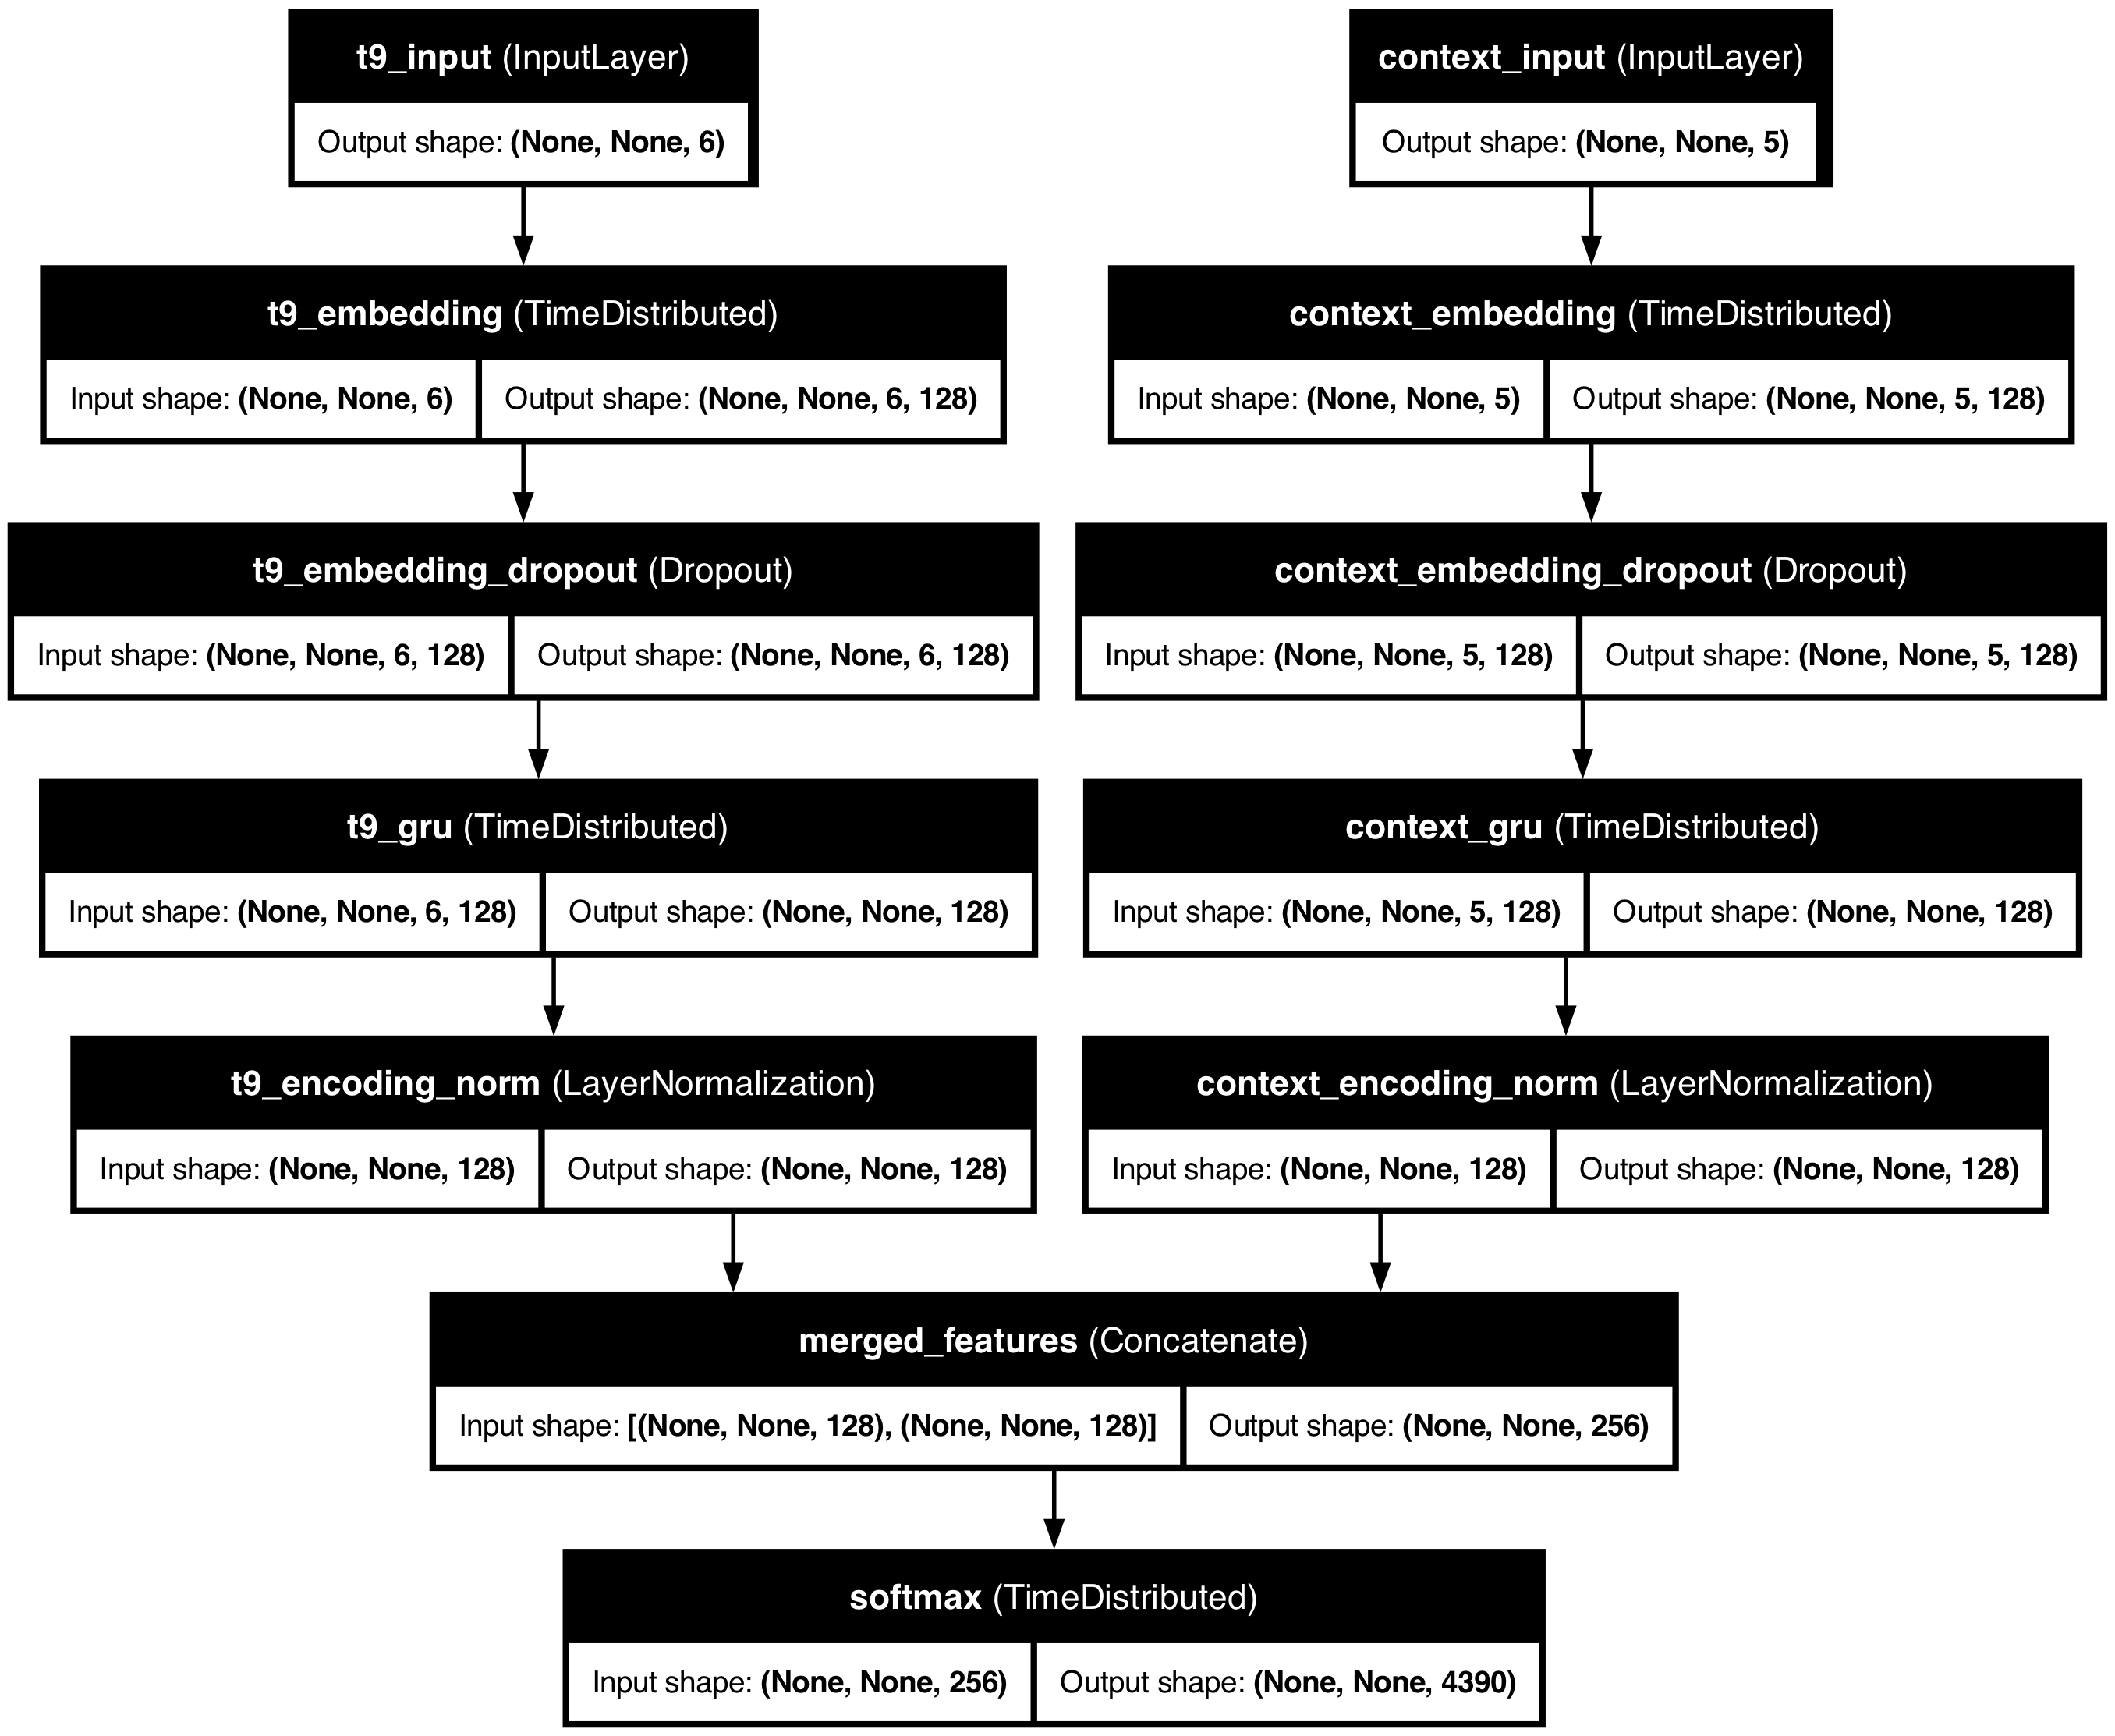

In [7]:
model = build_model(input_tv, target_tv, emb_size=128, gru_size=128, dropout=0.3)

if not tf.io.gfile.exists("png"):
    tf.io.gfile.makedirs("png")
    
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file="png/model_simple.png")

In [ ]:
model.fit(ds_train_padded, 
            epochs=50, 
            validation_data=ds_val_padded, 
            callbacks=[early_stopping, lr_scheduler],
            )

Epoch 1/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 6.7590 - perplexity: 638.1357 - sparse_categorical_accuracy: 0.1161 - weighted_sparse_categorical_accuracy: 0.1277

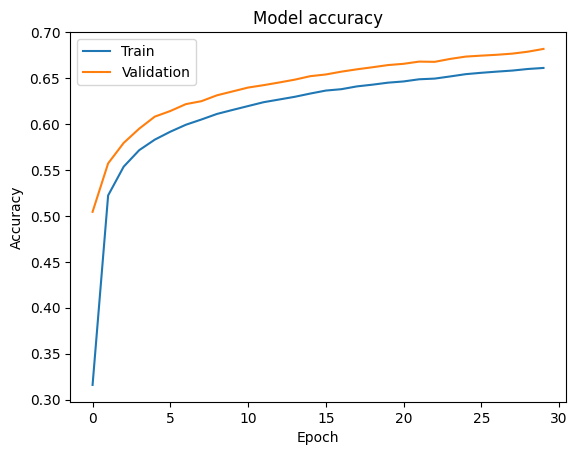

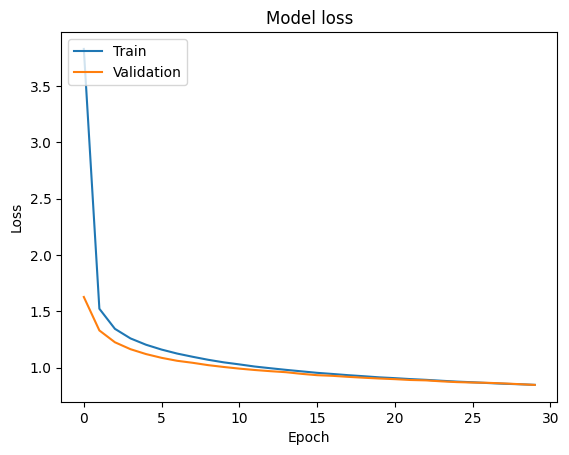

In [ ]:
plot_history(model.history, "png/model_simple")

In [51]:
if not tf.io.gfile.exists("models"):
    tf.io.gfile.makedirs("models")
    
# Sauvegarder le modèle
model.save("models/model_simple.keras")

In [52]:
# Custom layer to mask embeddings for token ID 1
@keras.saving.register_keras_serializable() #saving.register_keras_serializable => Permet de sauvegarder la couche personnalisée
class MaskToken1Layer(keras.layers.Layer):
    """
    Nous avons placé autant d'espaces vides que la taille de la fenêtre du contexte
    avant chaque séquence afin d'assurer que chaque caractère aura assez de `contexte`.
    Mais nous craignons que ces espaces (token ID 1) biaisent l'entraînement.
    Donc, nous avons personnalisé une couche pour masquer ces espaces de préfixe.
    """
    def __init__(self, **kwargs):
        super(MaskToken1Layer, self).__init__(**kwargs)

    def call(self, inputs, mask=None):
        embeddings, input_ids = inputs
        # Créer un masque où input_ids != 1
        mask_token_1 = tf.cast(tf.not_equal(input_ids, 1), tf.float32)

        # Développer le masque pour faire correspondre la forme des integers
        mask_token_1 = tf.expand_dims(mask_token_1, -1) # [batch_size, seq_len, 1]

        # Appliquer un masque aux intégres
        masked_embeddings = embeddings * mask_token_1

        return masked_embeddings

    def compute_mask(self, inputs, mask=None):
        embeddings, input_ids = inputs
        # Étant donné que Input_ids est un keras.tensor, nous comptons sur le fait que Keras
        # gère le masque pour nous.Nous n'avons pas besoin de calculer un nouveau masque ici
        # car nous utilisons mask_zero=True dans l'Embedding Layer.
        # Si mask est None, cela signifie que l'entrée n'est pas masquée
        # et nous devons renvoyer None pour indiquer qu'il n'y a pas de masque.
        if mask is not None:
            # Use the incoming mask (from mask_zero=True) if available
            return mask
        return None

    def get_config(self):
        # Récupérer la configuration de la couche parente
        config = super(MaskToken1Layer, self).get_config()
        # Ajouter des paramètres supplémentaires si nécessaire
        return config

In [53]:
def build_model_with_1_mask(input_tv, output_tv, emb_size, gru_size, dropout=0.3, context_size=5):
    # Inputs
    t9_input = keras.layers.Input(shape=(None, 6), name="t9_input")  # (batch, seq_len, t9_len)
    context_input = keras.layers.Input(shape=(None, context_size), name="context_input")  # (batch, seq_len, context_len)

    # ===== T9 processing =====
    t9_emb = keras.layers.TimeDistributed(
        keras.layers.Embedding(input_dim=input_tv.vocabulary_size(),
                         output_dim=emb_size,
                         mask_zero=True),
        name="t9_embedding")(t9_input)
    
    t9_emb = MaskToken1Layer(name="t9_mask_token_1")([t9_emb, t9_input])

    t9_emb = keras.layers.Dropout(dropout, name="t9_embedding_dropout")(t9_emb)

    t9_encoded = keras.layers.TimeDistributed(
        keras.layers.GRU(gru_size,
                   activation="tanh",
                   recurrent_activation="sigmoid",
                   dropout=dropout,
                   return_sequences=False,
                   kernel_regularizer=keras.regularizers.l2(0.01)),
        name="t9_gru")(t9_emb)

    t9_encoded = keras.layers.LayerNormalization(name="t9_encoding_norm")(t9_encoded)

    # ===== Context processing =====
    context_emb = keras.layers.TimeDistributed(
        keras.layers.Embedding(input_dim=output_tv.vocabulary_size(),
                         output_dim=emb_size,
                         mask_zero=True),
        name="context_embedding")(context_input)
    
    context_emb = MaskToken1Layer(name="context_mask_token_1")([context_emb, context_input])

    context_emb = keras.layers.Dropout(dropout, name="context_embedding_dropout")(context_emb)
    

    context_encoded = keras.layers.TimeDistributed(
        keras.layers.GRU(gru_size,
                   activation="tanh",
                   recurrent_activation="sigmoid",
                   dropout=dropout,
                   return_sequences=False,
                   kernel_regularizer=keras.regularizers.l2(0.01)),
        name="context_gru")(context_emb)

    context_encoded = keras.layers.LayerNormalization(name="context_encoding_norm")(context_encoded)

    # ===== Merge & Output =====
    merged = keras.layers.Concatenate(axis=-1, name="merged_features")([t9_encoded, context_encoded])

    output = keras.layers.TimeDistributed(
        keras.layers.Dense(output_tv.vocabulary_size(), activation="softmax"),
        name="softmax")(merged)

    model = keras.Model(inputs={"t9_input": t9_input, "context_input": context_input}, outputs=output)

    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[
            keras_hub.metrics.Perplexity(from_logits=False, mask_token_id=0),
            keras.metrics.SparseCategoricalAccuracy()],
        weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )

    return model

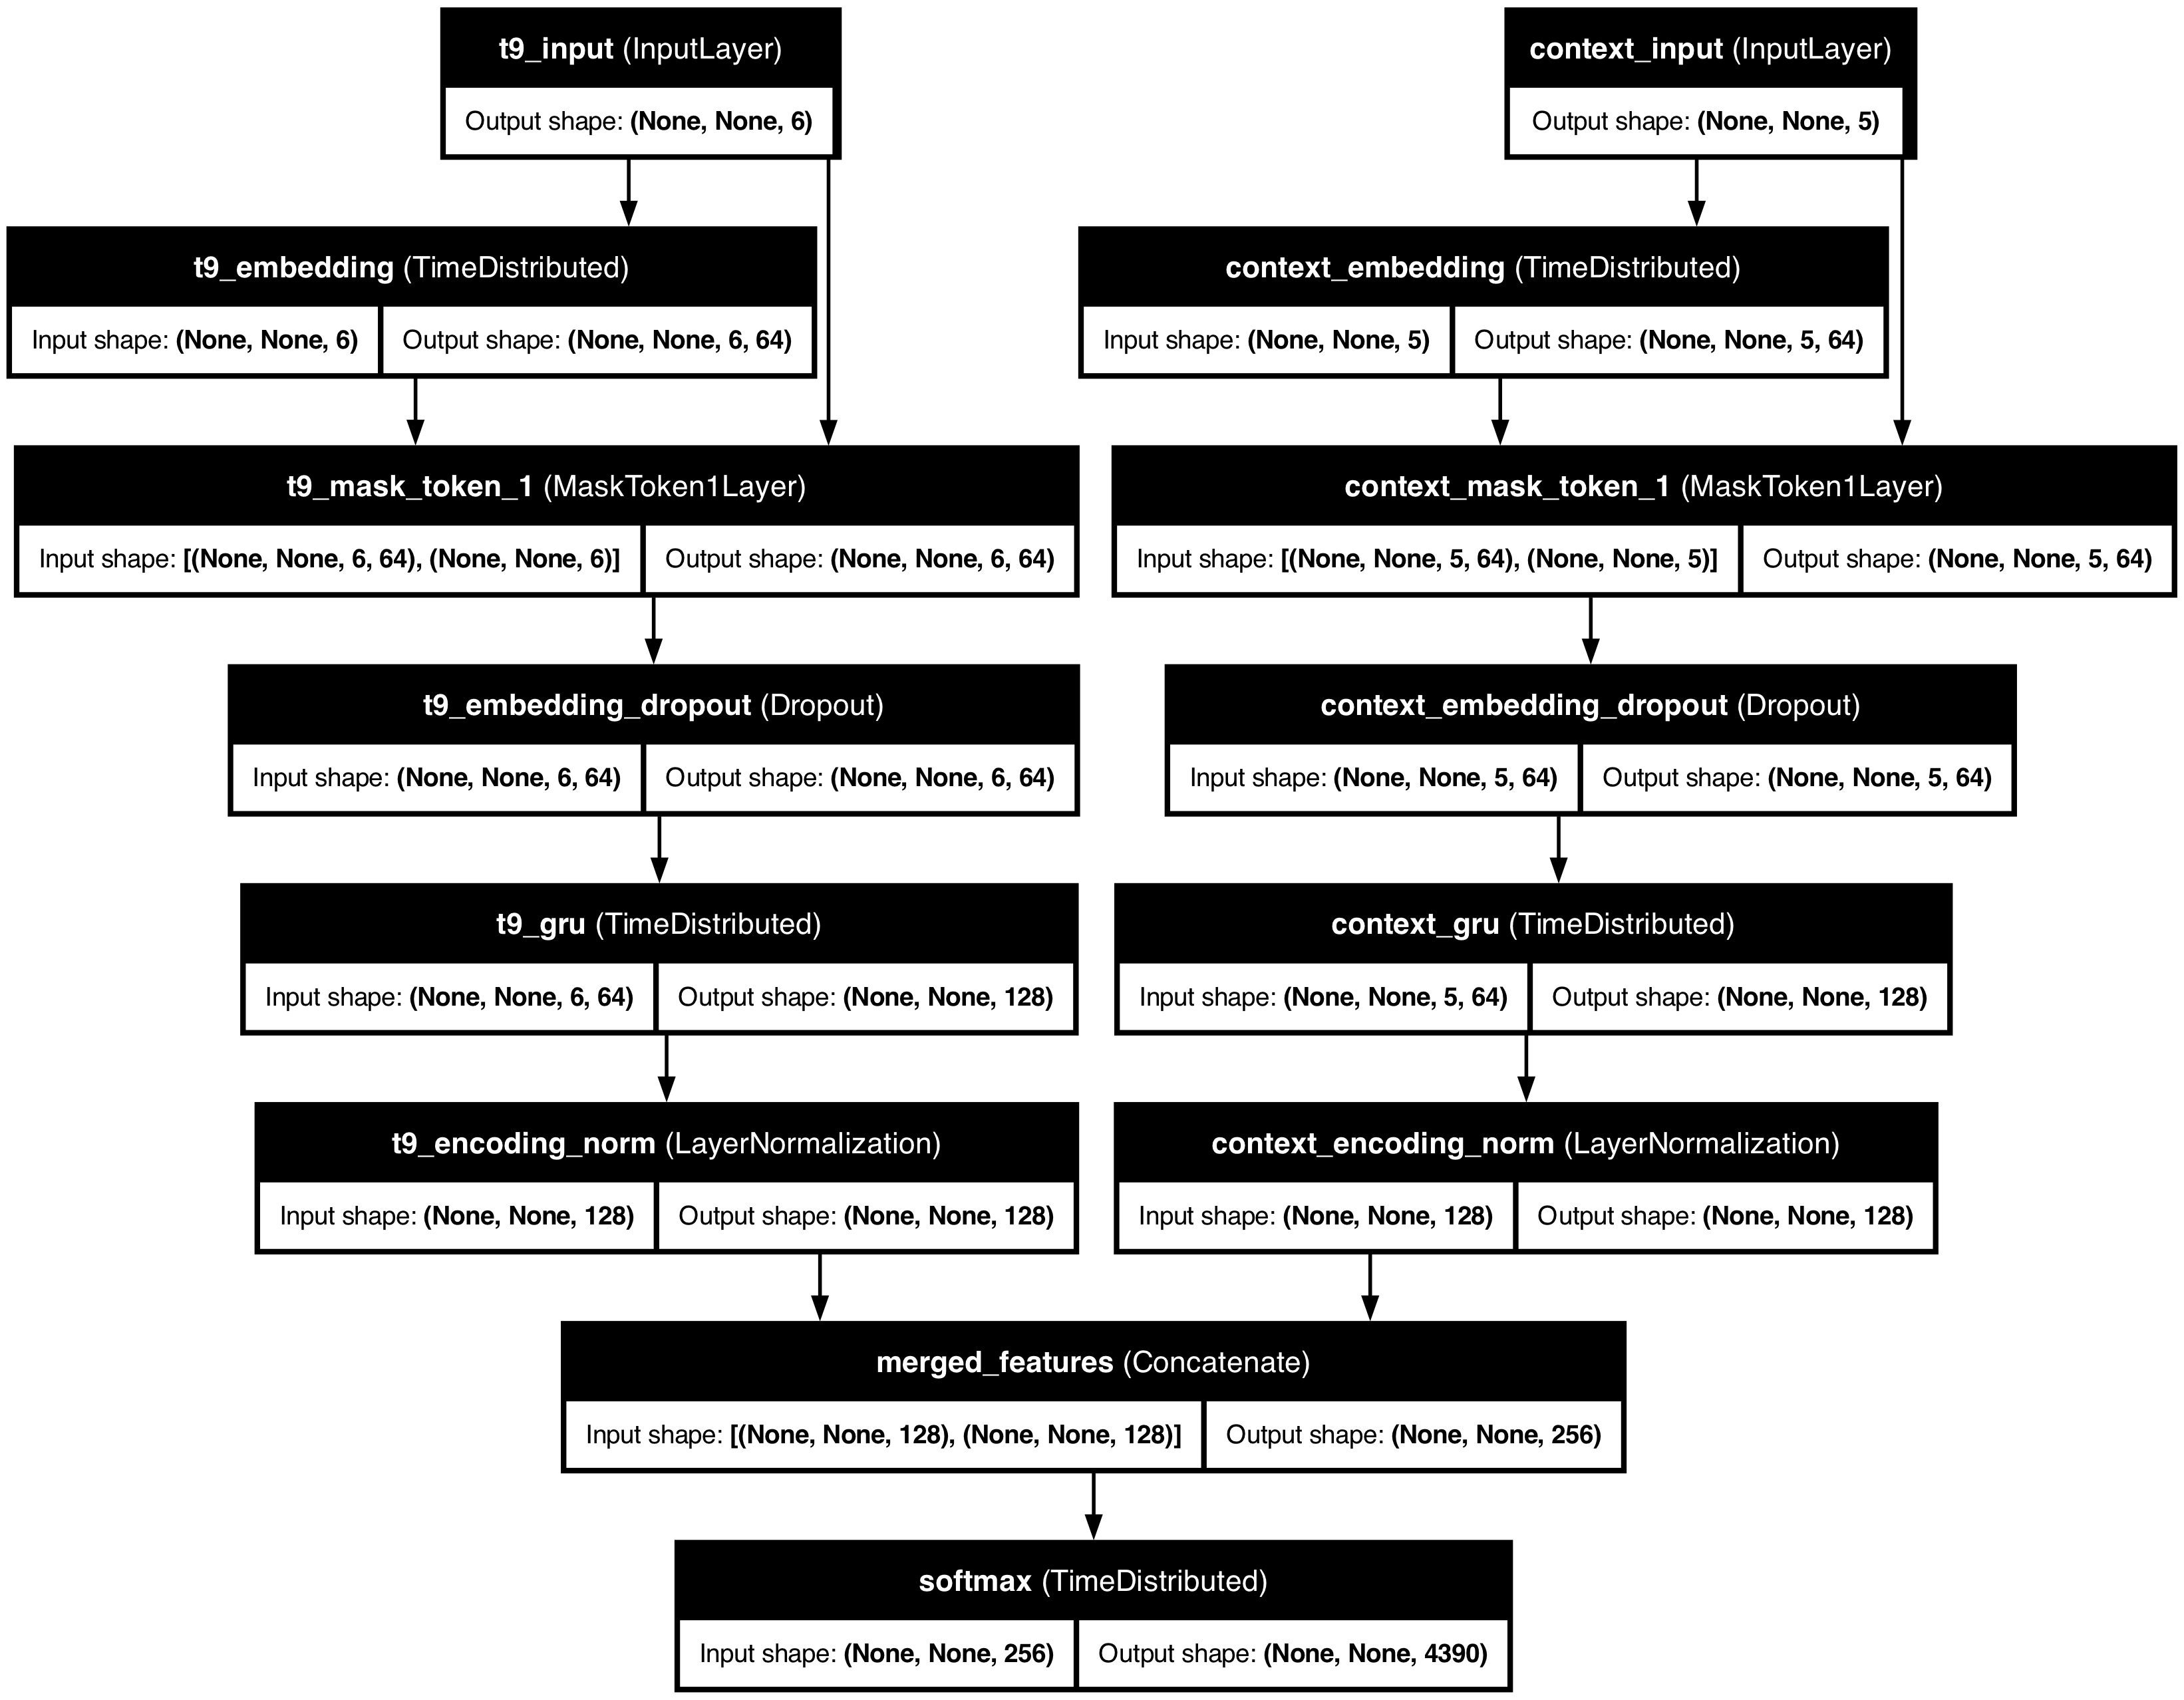

: 

In [ ]:
model_with_1_mask = build_model_with_1_mask(input_tv, target_tv, emb_size=64, gru_size=128, dropout=0.4)
keras.utils.plot_model(model_with_1_mask, show_shapes=True, show_layer_names=True, to_file="png/model_with_1_mask.png")

In [ ]:
model_with_1_mask.fit(ds_train_padded.take(100), 
                      epochs=30, 
                      validation_data=ds_val_padded.take(20), 
                      callbacks=[early_stopping, lr_scheduler],
                      )

Epoch 1/30


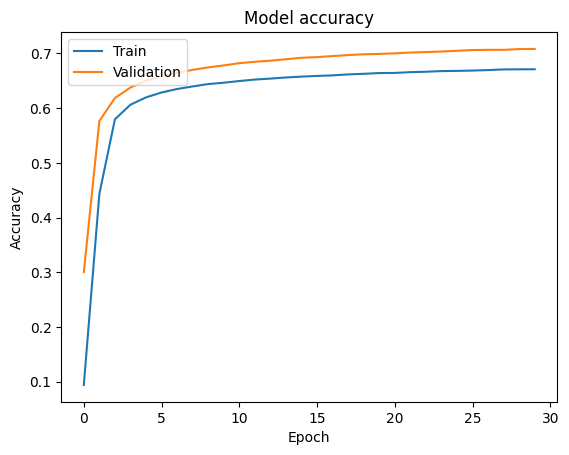

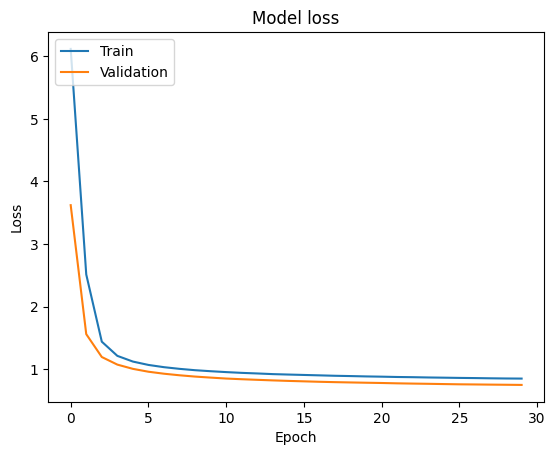

In [ ]:
plot_history(model_with_1_mask.history, "png/model_with_1_mask")

In [ ]:
model_with_1_mask.save("models/model_with_1_mask.keras")

[Tutoriel Seq2Seq avec Transformer](https://keras.io/examples/nlp/neural_machine_translation_with_transformer/)

In [12]:
def transformer_block(embed_dim, num_heads, ff_dim, rate=0.1):
    inputs = keras.Input(shape=(None, embed_dim))
    attention = keras.layers.MultiHeadAttention(
                            num_heads=num_heads, 
                            key_dim=embed_dim, 
                            kernel_regularizer=keras.regularizers.l2(0.01)
                            )(inputs, inputs)
    attention = keras.layers.Dropout(rate)(attention)
    out1 = keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    ffn = keras.Sequential([
                keras.layers.Dense(ff_dim, activation="relu"),
                keras.layers.Dense(embed_dim),
            ])
    ffn_output = ffn(out1)
    ffn_output = keras.layers.Dropout(rate)(ffn_output)
    outputs = keras.layers.LayerNormalization(epsilon=1e-6)(out1 + ffn_output)
    return keras.Model(inputs, outputs)

class PositionalEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        positions = tf.range(start=0, limit=seq_len, delta=1)
        positions = tf.expand_dims(positions, 0)  # [1, seq_len]
        return x + self.pos_emb(positions)  # broadcasting


def build_transformer_model(input_tv, target_tv, embed_dim=64, ff_dim=128, dropout=0.4, num_heads=4, num_layers=2, context_size=5, max_seq_len=128):
    # Inputs
    t9_input = keras.Input(shape=(None, 6), name="t9_input")  # (batch, seq_len, 6)
    context_input = keras.Input(shape=(None, context_size), name="context_input")  # (batch, seq_len, context_size)

    # ==== T9 Embedding ==== (batch, seq_len, 6) -> (batch, seq_len, 6, embed_dim)
    t9_emb = keras.layers.TimeDistributed(
        keras.layers.Embedding(input_tv.vocabulary_size(), embed_dim, mask_zero=True),
        name="t9_embedding"
    )(t9_input)

    t9_emb = MaskToken1Layer(name="t9_mask_token_1")([t9_emb, t9_input])

    # Passage par GRU pour chaque mot T9 (ex : '4663') => représentation vectorielle
    t9_encoded = keras.layers.TimeDistributed(
                        keras.layers.GRU(
                            embed_dim, 
                            return_sequences=False, 
                            kernel_regularizer=keras.regularizers.l2(0.01)
                            ),
                        name="t9_gru"
                    )(t9_emb)  # (batch, seq_len, embed_dim)

    # Ajout du positional encoding
    t9_encoded = PositionalEmbedding(max_seq_len, embed_dim)(t9_encoded)

    # Plusieurs couches Transformer (T9)
    for i in range(num_layers):
        t9_encoded = transformer_block(embed_dim, num_heads, ff_dim)(t9_encoded)

    # ===== Context processing =====
    context_emb = keras.layers.TimeDistributed(
        keras.layers.Embedding(target_tv.vocabulary_size(), embed_dim, mask_zero=True),
        name="context_embedding"
    )(context_input)

    context_emb = MaskToken1Layer(name="context_mask_token_1")([context_emb, context_input])

    # Encodage GRU de chaque contexte
    context_encoded = keras.layers.TimeDistributed(
                            keras.layers.GRU(
                                embed_dim, 
                                return_sequences=False, 
                                kernel_regularizer=keras.regularizers.l2(0.01)),
                            name="context_gru"
                        )(context_emb)

    context_encoded = PositionalEmbedding(max_seq_len, embed_dim)(context_encoded)

    # Plusieurs couches Transformer (contexte)
    for i in range(num_layers):
        context_encoded = transformer_block(embed_dim, num_heads, ff_dim)(context_encoded)

    # ===== Merge & Output =====
    merged = keras.layers.Concatenate()([t9_encoded, context_encoded])
    x = keras.layers.Dense(ff_dim, activation="relu")(merged)
    x = keras.layers.Dropout(dropout)(x)
    output = keras.layers.Dense(target_tv.vocabulary_size(), activation="softmax")(x)

    model = keras.Model(inputs={"t9_input": t9_input, "context_input": context_input}, outputs=output)

    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[
            keras_hub.metrics.Perplexity(from_logits=False, mask_token_id=0),
            keras.metrics.SparseCategoricalAccuracy()],
        weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )

    return model

In [ ]:
def build_tranformer_model_tuner(hp):
    embed_dim = hp.Choice("embed_dim", [32, 64, 128])
    ff_dim = hp.Choice("ff_dim", [32, 64, 128])
    num_heads = hp.Choice("num_heads", [2, 4, 8])
    num_layers = hp.Choice("num_layers", [1, 2, 3])
    dropout = hp.Float("dropout", min_value=0.0, max_value=0.8, step=0.2)

    model = build_transformer_model(
        input_tv, target_tv,
        embed_dim=embed_dim,
        ff_dim=ff_dim,
        dropout=dropout,
        num_heads=num_heads,
        num_layers=num_layers
    )

    return model


# Configurer le tuner
tuner = keras_tuner.GridSearch(
    build_tranformer_model_tuner,
    objective="val_sparse_categorical_accuracy",
    max_trials=10,
    directory="tuning",
    project_name="t9_transformer_tuning",
)

tuner.search(
    ds_train_padded,
    validation_data=ds_val_padded,
    epochs=10,
    callbacks=[early_stopping, lr_scheduler]
)

# Récupérer le meilleur modèle
best_model = tuner.get_best_models(num_models=1)[0]

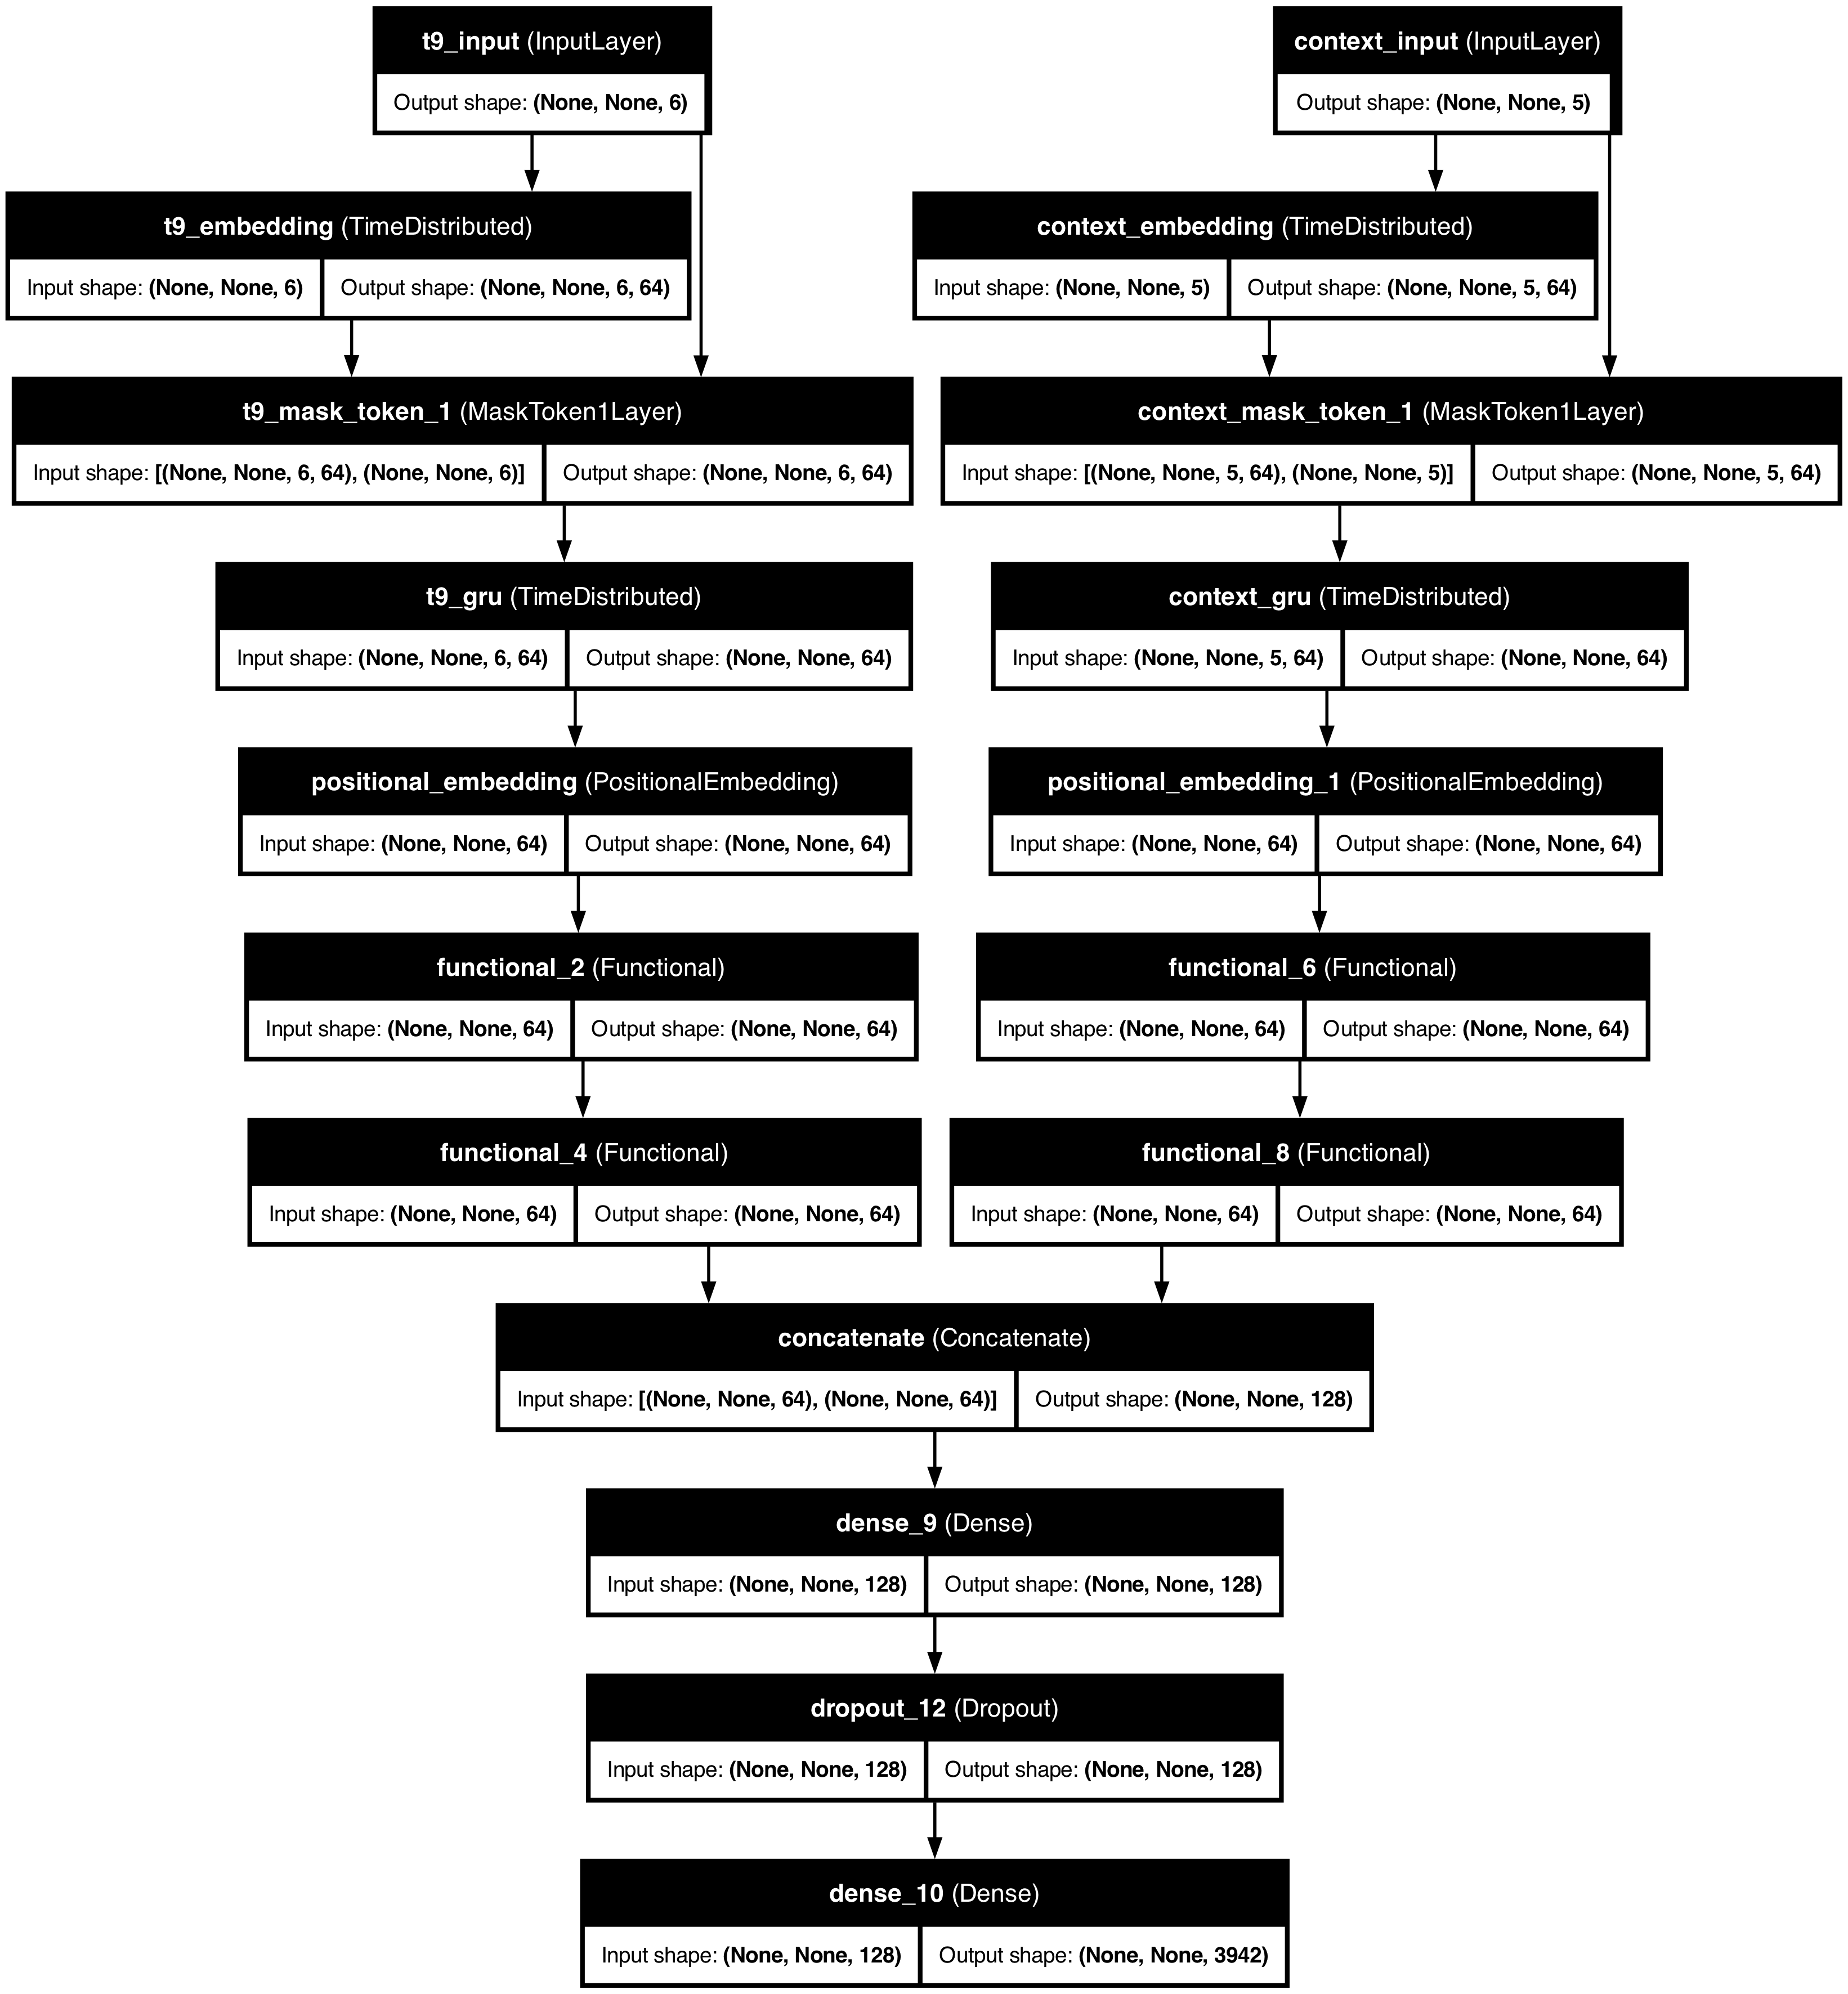

In [ ]:
model_transformer = build_transformer_model(input_tv, target_tv, embed_dim=64, ff_dim=128, dropout=0.4, num_heads=4, num_layers=2, context_size=context_size, max_seq_len=MAX_SEQUENCE_LENGTH)
keras.utils.plot_model(model_transformer, show_shapes=True, show_layer_names=True, to_file="png/model_transformer.png")

In [ ]:
model_transformer.fit(ds_train_padded.take(100), 
                      epochs=30, 
                      validation_data=ds_val_padded.take(20), 
                      callbacks=[early_stopping]
                      )

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - loss: 9.2269 - perplexity: 1132.6466 - sparse_categorical_accuracy: 0.0267 - weighted_sparse_categorical_accuracy: 0.0291 - val_loss: 3.6222 - val_perplexity: 37.8365 - val_sparse_categorical_accuracy: 0.2750 - val_weighted_sparse_categorical_accuracy: 0.2988
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 77s 767ms/step - loss: 3.1098 - perplexity: 26.3018 - sparse_categorical_accuracy: 0.3116 - weighted_sparse_categorical_accuracy: 0.3401 - val_loss: 1.8237 - val_perplexity: 6.9843 - val_sparse_categorical_accuracy: 0.5071 - val_weighted_sparse_categorical_accuracy: 0.5510
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 76s 757ms/step - loss: 1.9028 - perplexity: 7.7616 - sparse_categorical_accuracy: 0.4840 - weighted_sparse_categorical_accuracy: 0.5283 - val_loss: 1.4382 - val_perplexity: 4.6678 - val_sparse_categorical_accuracy: 0.5691 - val_weighted_sparse_categorical_accuracy: 0.6182
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 77s 763ms/step - l

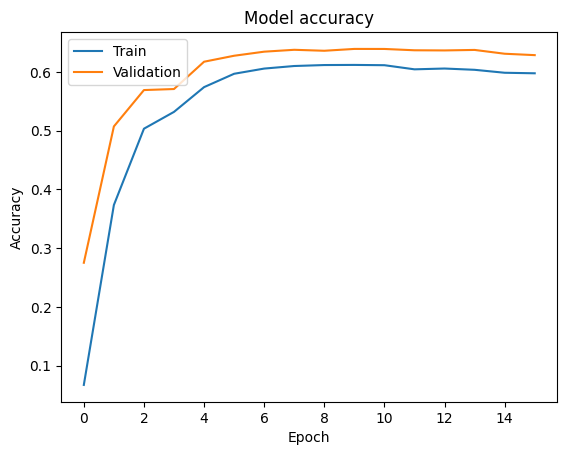

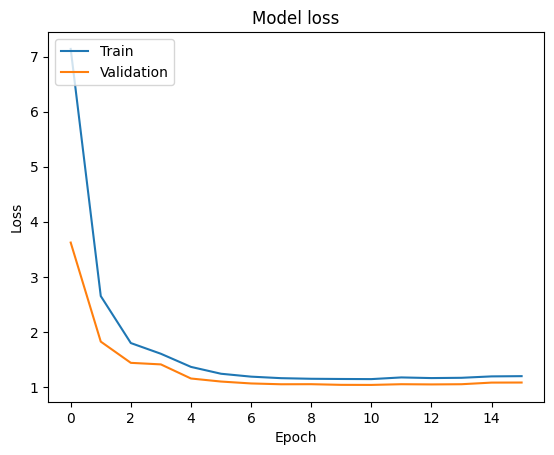

In [ ]:
plot_history(model_transformer.history, "png/model_transformer")

In [ ]:
model_transformer.save("models/model_transformer.keras")

# 4. Évaluation

Les modèles ont été évalués avec les métriques suivantes :

- **Loss (Cross-Entropy)** : Mesure la capacité du modèle à prédire correctement les caractères chinois. Plus la perte est faible, plus le modèle prédit précisément.
- **Perplexity** : Évalue à quel point le modèle est incertain dans ses prédictions. Une perplexité plus basse indique une meilleure performance.
- **Sparse Categorical Accuracy** : Indique la précision brute du modèle, exprimant la proportion des caractères prédits correctement sans tenir compte du déséquilibre éventuel des classes.
- **Weighted Sparse Categorical Accuracy** : Évalue la précision du modèle en tenant compte des déséquilibres dans les données, offrant une vision équilibrée des performances.

Résultats obtenus :

- Modèle GRU simple : Perte = 0.7289, Perplexité = 2.1695, Précision brute = 70.99%, Précision pondérée = 77.38%.
- Modèle GRU avec token 1 masqué : Perte = 0.7312, Perplexité = 2.1737, Précision brute = 70.95%, Précision pondérée = 77.33%.
- Modèle GRU avec Transformer : Perte = 1.0184, Perplexité = 2.9612, Précision brute = 64.21%, Précision pondérée = 69.99%.

Le modèle GRU simple présente les meilleurs résultats globaux, indiquant une adéquation forte aux données et une bonne généralisation. Le modèle Transformer, bien que théoriquement puissant, montre des difficultés avec le jeu de données actuel, probablement dues à la taille limitée du corpus, à la complexité du modèle ou encore à des hyperparamètres pas optimums.

In [16]:
def evaluate_models(model_simple, model_with_1_mask, model_transformer, ds_test):
    print("Évaluation du modèle simple...")
    metrics_simple = model_simple.evaluate(ds_test, verbose=1, return_dict=True)
    # print("Metrics returned for model_simple:", metrics_simple)

    print("\nÉvaluation du modèle avec 1 masqué...")
    metrics_1_mask = model_with_1_mask.evaluate(ds_test, verbose=1, return_dict=True)
    # print("Metrics returned for model_with_1_mask:", metrics_1_mask)

    print("\nÉvaluation du modèle Transformer...")
    metrics_transformer = model_transformer.evaluate(ds_test, verbose=1, return_dict=True)
    # print("Metrics returned for model_transformer:", metrics_transformer)
    
    # Extract metrics
    loss_simple = metrics_simple['loss']
    perplexity_simple = metrics_simple.get('perplexity', 0.0)  # Use .get() to handle missing metrics
    acc_simple = metrics_simple.get('sparse_categorical_accuracy', 0.0)
    weighted_acc_simple = metrics_simple.get('weighted_sparse_categorical_accuracy', 0.0)

    loss_1_mask = metrics_1_mask['loss']
    perplexity_1_mask = metrics_1_mask.get('perplexity', 0.0)
    acc_1_mask = metrics_1_mask.get('sparse_categorical_accuracy', 0.0)
    weighted_acc_1_mask = metrics_1_mask.get('weighted_sparse_categorical_accuracy', 0.0)

    loss_transformer = metrics_transformer['loss']
    perplexity_transformer = metrics_transformer.get('perplexity', 0.0)
    acc_transformer = metrics_transformer.get('sparse_categorical_accuracy', 0.0)
    weighted_acc_transformer = metrics_transformer.get('weighted_sparse_categorical_accuracy', 0.0)

    print(f"\nRésultats :")
    print(f"Modèle simple - Perte : {loss_simple:.4f}, Précision : {acc_simple:.4f}")
    print(f"Modèle avec 1 masqué - Perte : {loss_1_mask:.4f}, Précision : {acc_1_mask:.4f}")
    print(f"Modèle Transformer - Perte : {loss_transformer:.4f}, Précision : {acc_transformer:.4f}")

    return {
        "simple": {"loss": loss_simple, "accuracy": acc_simple, "perplexity": perplexity_simple, "weighted_accuracy": weighted_acc_simple},
        "with_1_mask": {"loss": loss_1_mask, "accuracy": acc_1_mask, "perplexity": perplexity_1_mask, "weighted_accuracy": weighted_acc_1_mask},
        "transformer" : {"loss": loss_transformer, "accuracy": acc_transformer, "perplexity": perplexity_transformer, "weighted_accuracy": weighted_acc_transformer}
    }

# Charger les deux modèles depuis les fichiers
model_simple = keras.models.load_model("models/model_simple.keras")
model_with_1_mask = keras.models.load_model("models/model_with_1_mask.keras", custom_objects={"MaskToken1Layer": MaskToken1Layer})
model_transformer = keras.models.load_model("models/model_transformer.keras", custom_objects={"PositionalEmbedding": PositionalEmbedding, "transformer_block": transformer_block, "MaskToken1Layer": MaskToken1Layer})

# Évaluer
results = evaluate_models(model_simple, model_with_1_mask, model_transformer, ds_test_padded)

/Users/perrineqhn/Desktop/M2/S2/Méthode en Apprentissage Automatique/tf_metal_env/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'positional_embedding', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/perrineqhn/Desktop/M2/S2/Méthode en Apprentissage Automatique/tf_metal_env/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'positional_embedding_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warning

Évaluation du modèle simple...
16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 669ms/step - loss: 0.7289 - perplexity: 2.1695 - sparse_categorical_accuracy: 0.7099 - weighted_sparse_categorical_accuracy: 0.7738

Évaluation du modèle avec 1 masqué...
16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 740ms/step - loss: 0.7312 - perplexity: 2.1737 - sparse_categorical_accuracy: 0.7095 - weighted_sparse_categorical_accuracy: 0.7733

Évaluation du modèle Transformer...
16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 757ms/step - loss: 1.0184 - perplexity: 2.9612 - sparse_categorical_accuracy: 0.6421 - weighted_sparse_categorical_accuracy: 0.6999

Résultats :
Modèle simple - Perte : 0.7317, Précision : 0.7112
Modèle avec 1 masqué - Perte : 0.7330, Précision : 0.7103
Modèle Transformer - Perte : 1.0190, Précision : 0.6429


## Evaluation "manuelle"

In [ ]:
def extract_triplets_from_row(t9_line: str, window_size: int = 6) -> List[Tuple[str, str, str]]:
    """
    Extrait une liste de triplets (context, t9, target_char) à partir d'une ligne de type :
    "云|yun|986 在|zai|924 天|tian|8426 ..."
    """
    # Séparer chaque triplet sinogramme/pinyin/T9
    items = t9_line.strip().split()
    parsed = [item.split('|') for item in items if len(item.split('|')) == 3]

    triplets = []
    for i in range(window_size, len(parsed)):
        # Contexte = les `window_size` sinogrammes précédents
        context = ''.join([p[0] for p in parsed[i - window_size:i]])
        # Prochaine entrée : code T9
        t9_next = parsed[i][2]
        # Prochaine sortie : sinogramme à prédire
        char_next = parsed[i][0]
        triplets.append((context, t9_next, char_next))

    return triplets

def build_evaluation_corpus(df: pd.DataFrame, window_size: int = 6) -> pd.DataFrame:
    """Construit un DataFrame avec colonnes ['context', 't9', 'target_char']."""
    all_triplets = []
    for seq in df['char_pinyin_t9_sequence']:
        all_triplets.extend(extract_triplets_from_row(seq, window_size))
    return pd.DataFrame(all_triplets, columns=["context", "t9", "target_char"])

In [ ]:
def evaluate_char_predictions(references: List[str], predictions: List[str]) -> Dict[str, float]:
    """
    Calcule la précision, le rappel et la F1-score pour une liste de chaînes de caractères sinogrammes.
    Chaque paire (ref, pred) est comparée caractère par caractère avec gestion des longueurs différentes.

    Args:
        references (List[str]): Réponses de référence (ground truth)
        predictions (List[str]): Réponses générées par le modèle

    Returns:
        Dict[str, float]: Dictionnaire avec 'precision', 'recall', 'f1'
    """
    y_true, y_pred = [], []
    for ref, pred in zip(references, predictions):
        min_len = min(len(ref), len(pred))
        y_true.extend(ref[:min_len])
        y_pred.extend(pred[:min_len])

        # FP pour surplus prédiction
        if len(pred) > min_len:
            y_pred.extend(pred[min_len:])
            y_true.extend(['[PAD]'] * (len(pred) - min_len))
        # FN pour surplus référence
        if len(ref) > min_len:
            y_true.extend(ref[min_len:])
            y_pred.extend(['[PAD]'] * (len(ref) - min_len))

    mask = [(t != '[PAD]' and p != '[PAD]') for t, p in zip(y_true, y_pred)]
    y_true_f = [t for t, m in zip(y_true, mask) if m]
    y_pred_f = [p for p, m in zip(y_pred, mask) if m]

    return {
        "precision": precision_score(y_true_f, y_pred_f, average="micro", zero_division=0),
        "recall":    recall_score(y_true_f, y_pred_f, average="micro", zero_division=0),
        "f1":        f1_score(y_true_f, y_pred_f, average="micro", zero_division=0)
    }

In [ ]:
# Charger et nettoyer
df = pd.read_csv(xml_corpus_to_csv)
df = df.dropna(subset=["char_pinyin_t9_sequence"])

# Construire le corpus d'évaluation
corpus_df = build_evaluation_corpus(df, window_size=6)
corpus_df.to_csv("corpus/corpus_t9_evaluation.csv", index=False)

# Charger modèle et layers
model = model_simple

# Mélanger et limiter le corpus à N exemples
N = 500  # nombre de paires à évaluer
subset_df = corpus_df.sample(frac=1, random_state=42).head(N)  # mélange aléatoire reproductible

# Boucle d'inférence
refs, preds = [], []
for _, row in subset_df.iterrows():
    refs.append(row["target_char"])
    pred = generate_text(model, row["t9"], row["context"], input_tv, target_tv)
    preds.append(pred)

# Évaluation
scores = evaluate_char_predictions(refs, preds)
print("Résultats :", scores)

# Génération

In [52]:
def generate_text(model, input_t9_sequence, context_chars, input_tv, target_tv, max_length=100, context_size=5):
    """
    Génère une séquence de caractères chinois à partir d'une séquence T9 et d'un contexte en sinogrammes.
    
    Args:
        model: Modèle Keras entraîné.
        input_t9_sequence: Chaîne de séquences T9 séparées par des espaces (ex. "94664 486").
        context_chars: Liste de caractères chinois pour le contexte initial (ex. ["经", "央"]).
        input_tv: Couche TextVectorization pour les entrées T9.
        target_tv: Couche TextVectorization pour les caractères cibles.
        max_length: Longueur maximale de la séquence générée.
        context_size: Taille du contexte (nombre de caractères précédents utilisés).
    
    Returns:
        Chaîne de caractères chinois générée.
    """
    # Préparer l'entrée T9
    t9_tokens = input_t9_sequence.strip().split(" ")
    t9_tokens = t9_tokens[:max_length]  # Limiter à max_length
    if not t9_tokens:
        return ""
    
    # Vectoriser les tokens T9
    t9_vectorized = input_tv(t9_tokens).to_tensor(default_value=0, shape=(len(t9_tokens), 6))
    t9_vectorized = tf.expand_dims(t9_vectorized, axis=0)  # Shape: (1, seq_len, 6)
    
    # Initialiser le contexte avec les caractères fournis
    context = []
    if context_chars:
        # Vectoriser les caractères de contexte
        context_ids = target_tv(context_chars).to_tensor(default_value=0).numpy().flatten().tolist()
        context.extend(context_ids)
    # Remplir avec des zéros si le contexte est trop court
    while len(context) < context_size:
        context.insert(0, 0)  # Padding avec 0 (sera masqué)
    # Tronquer si le contexte est trop long
    context = context[-context_size:]
    
    # Initialiser la séquence générée
    generated_chars = []
    
    # Générer caractère par caractère
    for i in range(len(t9_tokens)):
        # Préparer le contexte
        context_tensor = tf.constant([context[-context_size:]], dtype=tf.int64)
        context_tensor = tf.expand_dims(context_tensor, axis=1)  # Shape: (1, 1, context_size)
        context_tensor = tf.repeat(context_tensor, repeats=tf.shape(t9_vectorized)[1], axis=1)
        
        # Prédire le caractère suivant
        inputs = {
            "t9_input": t9_vectorized,
            "context_input": context_tensor
        }
        predictions = model.predict(inputs, verbose=0)  # Shape: (1, seq_len, vocab_size)
        
        # Obtenir la prédiction pour la position actuelle
        pred_char_idx = np.argmax(predictions[0, i], axis=-1)
        pred_char = target_tv.get_vocabulary()[pred_char_idx]
        
        # Ajouter le caractère généré (sauf si c'est un token spécial)
        if pred_char not in ['', '[UNK]']:
            generated_chars.append(pred_char)
        
        # Mettre à jour le contexte
        context.append(int(pred_char_idx))
        if len(context) > context_size:
            context.pop(0)
    
    # Convertir la liste de caractères en chaîne
    return ''.join(generated_chars)

In [53]:
test_cases = [
    {
        "t9_input": "94664 486",  # 中国
        "context_chars": ["经", "央"],  # Contexte: caractères précédents
        "description": "Générer '中国' avec contexte '经央'",
        "expected": "中国"
    },
    {
        "t9_input": "5464 94664 9264",  # 经中央
        "context_chars": ["广", "大"],  # Contexte: caractères précédents
        "description": "Générer '经中央' avec contexte '广大'",
        "expected": "经中央"
    },
    {
        "t9_input": "48264 32 3264",  # 广大党
        "context_chars": ["中", "国"],  # Contexte: caractères précédents
        "description": "Générer '广大党' avec contexte '中国'",
        "expected": "广大党"
    },
    {
        "t9_input": "1 94664 486",  # masked token + 中国
        "context_chars": ["党"],  # Contexte minimum
        "description": "Tester le masquage de l'ID de token 1 avec '中国' et le contexte '党'",
        "expected": "中国"  # Token ID 1 should be ignored
    },
    {
        "t9_input": "0 94664 486",  # Padding + 中国
        "context_chars": ["经", "央", "广"],  # Contexte long
        "description": "Tester le masquage de l'ID de token 0 avec '中国' et le contexte '经央广'",
        "expected": "中国"  # Token ID 0 should be ignored
    },
    {
        "t9_input": "94664 486 5464 94664 9264",  # 中国经中央
        "context_chars": [],  # Aucun contexte
        "description": "Générer '中国经中央' sans contexte",
        "expected": "中国经中央"
    }
]

for test_case in test_cases:
    generated_text = generate_text(
        model_simple,
        test_case["t9_input"],
        test_case["context_chars"],
        input_tv,
        target_tv
    )
    print(f"Test case: {test_case['description']}")
    print(f"Expected: {test_case['expected']}")
    print(f"Generated: {generated_text}")
    print("-" * 50)

Test case: Générer '中国' avec contexte '经央'
Expected: 中国
Generated: 中国
--------------------------------------------------
Test case: Générer '经中央' avec contexte '广大'
Expected: 经中央
Generated: 精中央
--------------------------------------------------
Test case: Générer '广大党' avec contexte '中国'
Expected: 广大党
Generated: 广大当
--------------------------------------------------
Test case: Tester le masquage de l'ID de token 1 avec '中国' et le contexte '党'
Expected: 中国
Generated: 的中国
--------------------------------------------------
Test case: Tester le masquage de l'ID de token 0 avec '中国' et le contexte '经央广'
Expected: 中国
Generated: 举行国
--------------------------------------------------
Test case: Générer '中国经中央' sans contexte
Expected: 中国经中央
Generated: 中国经中央
--------------------------------------------------


In [54]:
for test_case in test_cases:
    generated_text = generate_text(
        model_with_1_mask,
        test_case["t9_input"],
        test_case["context_chars"],
        input_tv,
        target_tv
    )
    print(f"Test case: {test_case['description']}")
    print(f"Expected: {test_case['expected']}")
    print(f"Generated: {generated_text}")
    print("-" * 50)

Test case: Générer '中国' avec contexte '经央'
Expected: 中国
Generated: 中国
--------------------------------------------------
Test case: Générer '经中央' avec contexte '广大'
Expected: 经中央
Generated: 精中央
--------------------------------------------------
Test case: Générer '广大党' avec contexte '中国'
Expected: 广大党
Generated: 广大党
--------------------------------------------------
Test case: Tester le masquage de l'ID de token 1 avec '中国' et le contexte '党'
Expected: 中国
Generated: 科中国
--------------------------------------------------
Test case: Tester le masquage de l'ID de token 0 avec '中国' et le contexte '经央广'
Expected: 中国
Generated: 剧中国
--------------------------------------------------
Test case: Générer '中国经中央' sans contexte
Expected: 中国经中央
Generated: 中国经中央
--------------------------------------------------


In [55]:
for test_case in test_cases:
    generated_text = generate_text(
        model_transformer,
        test_case["t9_input"],
        test_case["context_chars"],
        input_tv,
        target_tv
    )
    print(f"Test case: {test_case['description']}")
    print(f"Expected: {test_case['expected']}")
    print(f"Generated: {generated_text}")
    print("-" * 50)

Test case: Générer '中国' avec contexte '经央'
Expected: 中国
Generated: 中国
--------------------------------------------------
Test case: Générer '经中央' avec contexte '广大'
Expected: 经中央
Generated: 精重养
--------------------------------------------------
Test case: Générer '广大党' avec contexte '中国'
Expected: 广大党
Generated: 广大党
--------------------------------------------------
Test case: Tester le masquage de l'ID de token 1 avec '中国' et le contexte '党'
Expected: 中国
Generated: 学种过
--------------------------------------------------
Test case: Tester le masquage de l'ID de token 0 avec '中国' et le contexte '经央广'
Expected: 中国
Generated: 组中国
--------------------------------------------------
Test case: Générer '中国经中央' sans contexte
Expected: 中国经中央
Generated: 众或失众脏
--------------------------------------------------


# 5. Conclusion

Pour rappeler les performances de différents modèles : 
- Modèle GRU simple : Perte = 0.7289, Perplexité = 2.1695, Précision brute = 70.99%, Précision pondérée = 77.38%.
- Modèle GRU avec token 1 masqué : Perte = 0.7312, Perplexité = 2.1737, Précision brute = 70.95%, Précision pondérée = 77.33%.
- Modèle GRU avec Transformer : Perte = 1.0184, Perplexité = 2.9612, Précision brute = 64.21%, Précision pondérée = 69.99%.

**Le modèle GRU simple est le plus performant et le plus adapté à notre jeu de données**

1. Entre le modèle GRU simple et le modèle GRU avec token ID 1 masqué, les performances sont quasiment identiques. Cela pourrait prouver que le masquage explicite du token id 1 (l'espace vide) n'a pas d'amélioration significative et que le modèle simple a réussi à apprendre à ignorer ce token implicite.

    Commentaires : L'absence de l'amélioration dans le modèle avec token ID 1 masqué confirme indirectement que les embeddings ou le traitement des séquences par GRU sont suffisamment robustes pour négliger les tokens peu ou non informatifs.

2. Le modèle avec Transformer montre des performances inférieures au modèle GRU (plus grande perte, perplexité plus élevé, moins de précisions). La raison probable est que la taille du corpus d'entraînement est trop petit car nous avons seulement pris 100 batchs avec une batch_size de 128 comme données d'entraînement (donc 1280 séquences sur 16503). Souvent pour un corpus de petite taille, la performance d'un modèle GRU est meilleur qu'un modèle Transformer. Il est aussi possible que le mécanisme d'attention apporte trop de paramètres supplémentaires, ce qui fait que le modèle a du mal à bien apprendre. Par ailleurs, l'enrichissement des embeddings de GRU par ceux de Transformer pourrait écraser les bonnes représentations vectorielles issues du GRU. Donc, les embeddings de GRU sont probablement déjà suffisamment informatifs pour notre tâche, l'ajout du Transformer n'améliore pas le modèle simple et augmente le coût computationnel.

    Commentaires : Depuis cette expérience, on peut voir que l'ajout d'un composant puissant n'est utile que si les données en bénéficient réellement.

En général, le modèle GRU simple est léger, efficace et bien adapté à notre tâche, le masquage explicite des tokens spéciaux n'apporte pas vraiment de bénéfice et l'ajout d'un composant de Transformer ne garantit pas toujours une meilleure performance.

# 6. Perspective

- On aimerait étendre les entraînements sur l'ensemble du corpus d'entraînement si l'on disposait assez de ressources computationnelles pour voir si l'ajout d'un composant de Transformer pourrait améliorer les performances dans ce cas.
- On aimerait aussi terminer tous les essais de `keras_tuner` pour trouver des meilleurs hyperparamètres comme la taille du batch, l'unité dans les couches de neurones, la valeur de dropout, etc.
- Dans nos expériences actuelles, nous avons ajouté du padding pour que chaque caractère ait assez de contexte. Mais on aimerait également tester le cas où l'on commence l'entraînement à partir du (N+1)ème caractère (N est la taille de la fenêtre du contexte) sans ajouter du padding.